In [1]:
from ortools.constraint_solver import routing_enums_pb2
from ortools.constraint_solver import pywrapcp
import time as time_module
import numpy as np
import pandas as pd
import os
import time
import re
from Dataset_Generation import generate_multiple_datasets
import pyomo.environ as pyo
from pyomo.opt import SolverFactory
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

## Loading benchmarks data and generating synthetic datasets

In [2]:
def load_solomon_instance(filepath):
    customer_data = []
    vehicle_info = {}
    parsing_customers = False
    parsing_vehicles = False
    
    with open(filepath, 'r') as file:
        for line in file:
            stripped = line.strip()
            parts = line.split()
            
            if not parts:
                continue
            if "VEHICLE" in line:
                parsing_vehicles = True
                continue
            if parsing_vehicles and not parsing_customers:
                if "NUMBER" in line or "CAPACITY" in line:
                    continue
                if len(parts) == 2:
                    try:
                        vehicle_info['n_vehicles'] = int(parts[0])
                        vehicle_info['vehicle_capacity'] = int(parts[1])
                        parsing_vehicles = False
                    except ValueError:
                        pass
                continue
            if "CUSTOMER" in line:
                parsing_customers = True
                continue
            if parsing_customers and "CUST" in line:
                continue
            if parsing_customers:
                if len(parts) >= 7:
                    try:
                        customer_data.append({
                            'id': int(parts[0]),
                            'x': float(parts[1]),
                            'y': float(parts[2]),
                            'demand': int(parts[3]),
                            'ready_time': int(parts[4]),
                            'due_time': int(parts[5]),
                            'service_time': int(parts[6])
                        })
                    except (ValueError, IndexError) as e:
                        print(f"Error parsing line: {line.strip()} -> {e}")
                        continue
    
    df = pd.DataFrame(customer_data)
    print(f"Loaded Solomon instance: {os.path.basename(filepath)}")
    print(f"  Customers: {len(df)-1}")
    print(f"  Vehicles: {vehicle_info.get('n_vehicles', 'N/A')}")
    print(f"  Capacity: {vehicle_info.get('vehicle_capacity', 'N/A')}")    
    return df, vehicle_info


def load_homberger_instance(filepath):
    return load_solomon_instance(filepath)

def test_benchmark_loading(dirpath):
    benchmark_dir = dirpath
    
    print(f"Directory exists: {benchmark_dir}")
    if not os.path.exists(benchmark_dir):
        print(f"Directory {benchmark_dir} not found")
        print("Please create it and add benchmark files")
        return
    files = [f for f in os.listdir(benchmark_dir) if f.endswith('.txt') or f.endswith('.TXT')]
    if not files:
        print("No .txt files found in benchmark directory")
    return files
    

In [3]:
solomon_graphs = test_benchmark_loading('./solomon-100/')
test_file1 = os.path.join('./solomon-100/', solomon_graphs[0])
df_test1, vehicle_info_test1 = load_solomon_instance(test_file1)

print(f"\nSample data:")
print(df_test1.head(10))
print(f"\nVehicle info: {vehicle_info_test1}")
print(f"\nDataFrame shape: {df_test1.shape}")
print(f"Columns: {df_test1.columns.tolist()}")


Directory exists: ./solomon-100/
Loaded Solomon instance: c101.txt
  Customers: 100
  Vehicles: 25
  Capacity: 200

Sample data:
   id     x     y  demand  ready_time  due_time  service_time
0   0  40.0  50.0       0           0      1236             0
1   1  45.0  68.0      10         912       967            90
2   2  45.0  70.0      30         825       870            90
3   3  42.0  66.0      10          65       146            90
4   4  42.0  68.0      10         727       782            90
5   5  42.0  65.0      10          15        67            90
6   6  40.0  69.0      20         621       702            90
7   7  40.0  66.0      20         170       225            90
8   8  38.0  68.0      20         255       324            90
9   9  38.0  70.0      10         534       605            90

Vehicle info: {'n_vehicles': 25, 'vehicle_capacity': 200}

DataFrame shape: (101, 7)
Columns: ['id', 'x', 'y', 'demand', 'ready_time', 'due_time', 'service_time']


In [5]:
print(solomon_graphs)

['c101.txt', 'c102.txt', 'c103.txt', 'c104.txt', 'c105.txt', 'c106.txt', 'c107.txt', 'c108.txt', 'c109.txt', 'c201.txt', 'c202.txt', 'c203.txt', 'c204.txt', 'c205.txt', 'c206.txt', 'c207.txt', 'c208.txt', 'r101.txt', 'r102.txt', 'r103.txt', 'r104.txt', 'r105.txt', 'r106.txt', 'r107.txt', 'r108.txt', 'r109.txt', 'r110.txt', 'r111.txt', 'r112.txt', 'r201.txt', 'r202.txt', 'r203.txt', 'r204.txt', 'r205.txt', 'r206.txt', 'r207.txt', 'r208.txt', 'r209.txt', 'r210.txt', 'r211.txt', 'rc101.txt', 'rc102.txt', 'rc103.txt', 'rc104.txt', 'rc105.txt', 'rc106.txt', 'rc107.txt', 'rc108.txt', 'rc201.txt', 'rc202.txt', 'rc203.txt', 'rc204.txt', 'rc205.txt', 'rc206.txt', 'rc207.txt', 'rc208.txt']


In [6]:
homberger_graphs = test_benchmark_loading('./homberger-1000/')
test_file2 = os.path.join('./homberger-1000/', homberger_graphs[0])
df_test2, vehicle_info_test2 = load_homberger_instance(test_file2)

print(f"\nSample data:")
print(df_test2.head(10))
print(f"\nVehicle info: {vehicle_info_test2}")
print(f"\nDataFrame shape: {df_test2.shape}")
print(f"Columns: {df_test2.columns.tolist()}")


Directory exists: ./homberger-1000/
Loaded Solomon instance: C1_10_1.TXT
  Customers: 1000
  Vehicles: 250
  Capacity: 200

Sample data:
   id      x      y  demand  ready_time  due_time  service_time
0   0  250.0  250.0       0           0      1824             0
1   1  387.0  297.0      10         200       270            90
2   2    5.0  297.0      10         955      1017            90
3   3  355.0  177.0      20         194       245            90
4   4   78.0  346.0      30         355       403            90
5   5  286.0  159.0      20         530       597            90
6   6  322.0  465.0      10         226       291            90
7   7  393.0  408.0      30         630       708            90
8   8   89.0  216.0      10         495       562            90
9   9   76.0  345.0      30         539       586            90

Vehicle info: {'n_vehicles': 250, 'vehicle_capacity': 200}

DataFrame shape: (1001, 7)
Columns: ['id', 'x', 'y', 'demand', 'ready_time', 'due_time', 'service_

In [7]:
print(homberger_graphs)

['C1_10_1.TXT', 'C1_10_10.TXT', 'C1_10_2.TXT', 'C1_10_3.TXT', 'C1_10_4.TXT', 'C1_10_5.TXT', 'C1_10_6.TXT', 'C1_10_7.TXT', 'C1_10_8.TXT', 'C1_10_9.TXT', 'C2_10_1.TXT', 'C2_10_10.TXT', 'C2_10_2.TXT', 'C2_10_3.TXT', 'C2_10_4.TXT', 'C2_10_5.TXT', 'C2_10_6.TXT', 'C2_10_7.TXT', 'C2_10_8.TXT', 'C2_10_9.TXT', 'R1_10_1.TXT', 'R1_10_10.TXT', 'R1_10_2.TXT', 'R1_10_3.TXT', 'R1_10_4.TXT', 'R1_10_5.TXT', 'R1_10_6.TXT', 'R1_10_7.TXT', 'R1_10_8.TXT', 'R1_10_9.TXT', 'R2_10_1.TXT', 'R2_10_10.TXT', 'R2_10_2.TXT', 'R2_10_3.TXT', 'R2_10_4.TXT', 'R2_10_5.TXT', 'R2_10_6.TXT', 'R2_10_7.TXT', 'R2_10_8.TXT', 'R2_10_9.TXT', 'RC1_10_1.TXT', 'RC1_10_10.TXT', 'RC1_10_2.TXT', 'RC1_10_3.TXT', 'RC1_10_4.TXT', 'RC1_10_5.TXT', 'RC1_10_6.TXT', 'RC1_10_7.TXT', 'RC1_10_8.TXT', 'RC1_10_9.TXT', 'RC2_10_1.TXT', 'RC2_10_10.TXT', 'RC2_10_2.TXT', 'RC2_10_3.TXT', 'RC2_10_4.TXT', 'RC2_10_5.TXT', 'RC2_10_6.TXT', 'RC2_10_7.TXT', 'RC2_10_8.TXT', 'RC2_10_9.TXT']


Basic dataset: 


 Dataset Statistics:
  Customers: 40
  Vehicles: 5
  Vehicle capacity: 200
  Total demand: 597.0
  Fleet capacity: 1000
  Utilization: 59.7% (target: 65%)
  Average demand per customer: 14.9
  Average time window width: 253.3 minutes
  Depot operating window: 0–576 min (9.0 hours)

  Time of day distribution:
    Morning (0–2h): 18
    Midday (2–4h): 21
    Afternoon (4h+): 1

  Window flexibility:
    Tight (<2h): 0
    Moderate (2–3h): 0
    Flexible (≥3h): 40

 Visualization saved to vrptw_easy_visualization.png


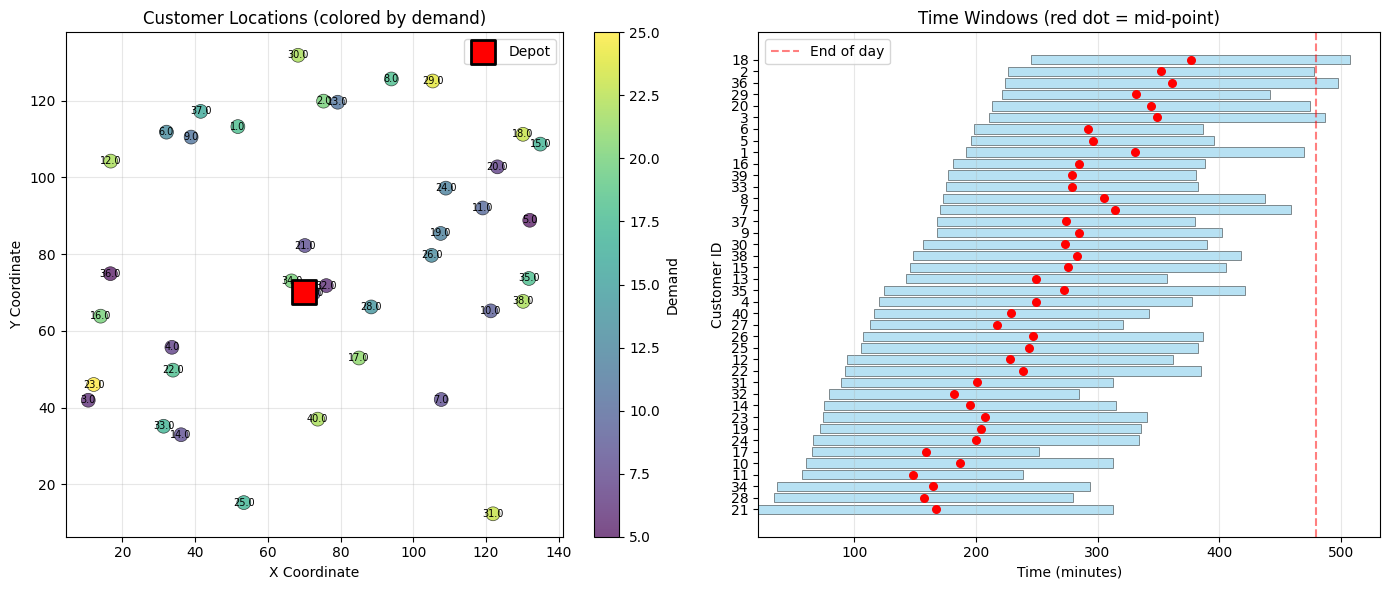

Intermediate dataset: 


⚙️ Adjusting vehicles from 10 → 16 to achieve ~65% utilization.

 Dataset Statistics:
  Customers: 100
  Vehicles: 16
  Vehicle capacity: 150
  Total demand: 1484.0
  Fleet capacity: 2400
  Utilization: 61.8% (target: 65%)
  Average demand per customer: 14.8
  Average time window width: 304.6 minutes
  Depot operating window: 0–720 min (12.0 hours)

  Time of day distribution:
    Morning (0–2h): 29
    Midday (2–4h): 64
    Afternoon (4h+): 7

  Window flexibility:
    Tight (<2h): 0
    Moderate (2–3h): 0
    Flexible (≥3h): 100

 Visualization saved to vrptw_medium_visualization.png


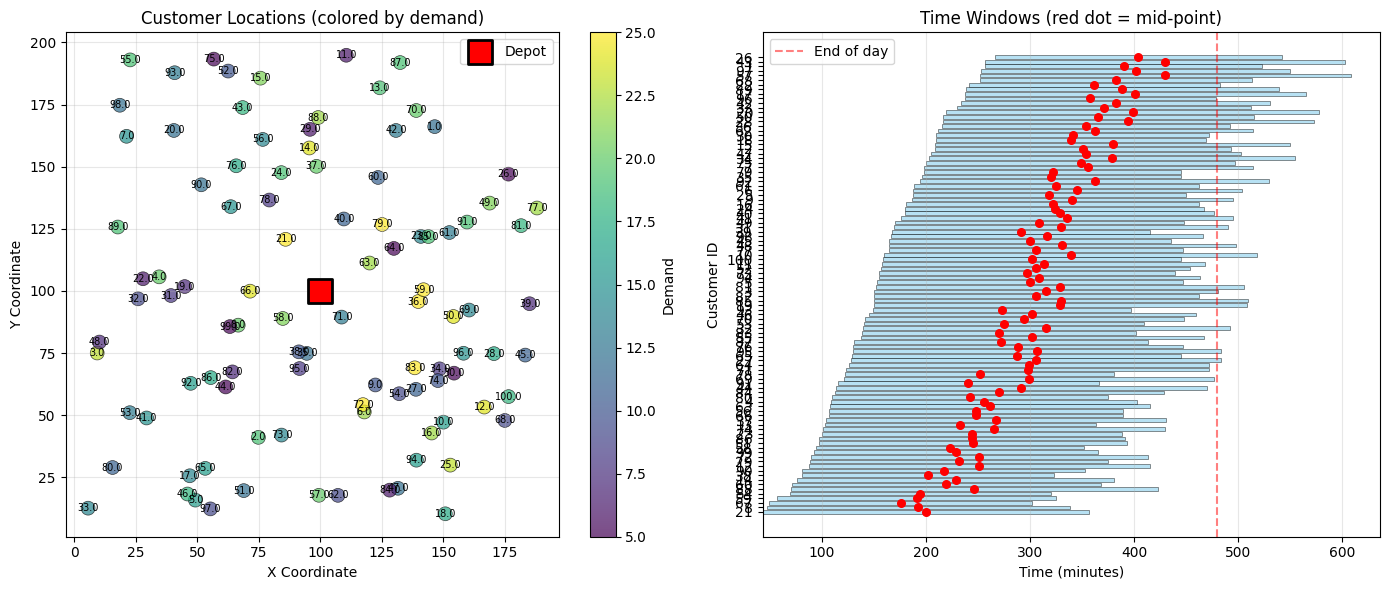

Advanced dataset: 


⚙️ Adjusting vehicles from 25 → 37 to achieve ~65% utilization.

 Dataset Statistics:
  Customers: 250
  Vehicles: 37
  Vehicle capacity: 150
  Total demand: 3600.0
  Fleet capacity: 5550
  Utilization: 64.9% (target: 65%)
  Average demand per customer: 14.4
  Average time window width: 393.0 minutes
  Depot operating window: 0–1080 min (18.0 hours)

  Time of day distribution:
    Morning (0–2h): 23
    Midday (2–4h): 132
    Afternoon (4h+): 95

  Window flexibility:
    Tight (<2h): 0
    Moderate (2–3h): 0
    Flexible (≥3h): 250

 Visualization saved to vrptw_hard_visualization.png


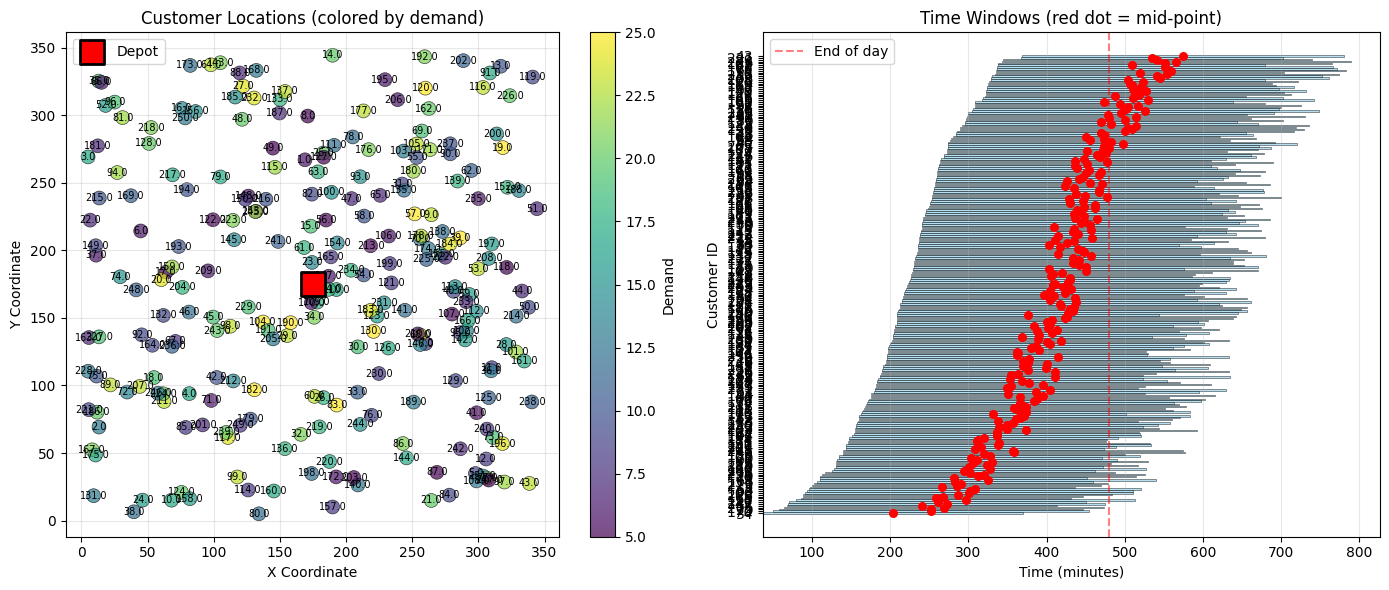

In [8]:
generated_datasets = generate_multiple_datasets()

In [8]:
easy_graph = generated_datasets['easy']
intermediate_graph = generated_datasets['medium']
advanced_graph = generated_datasets['hard']

### Adding feasibility checks

In [9]:
def validate_dataset_feasibility(df, vehicle_info):
    print("Feasibility check: \n")
    total_demand = df[df['id'] > 0]['demand'].sum()
    fleet_capacity = vehicle_info['n_vehicles'] * vehicle_info['vehicle_capacity']
    print(f"\n1. CAPACITY CHECK:")
    print(f"   Total demand: {total_demand}")
    print(f"   Fleet capacity: {fleet_capacity}")
    print(f"   Utilization: {total_demand/fleet_capacity*100:.1f}%")
    if total_demand > fleet_capacity:
        print(f"   INFEASIBLE: Demand exceeds capacity!")
        return False
    else:
        print(f"   Capacity is sufficient")
    
    print(f"\n2. TIME WINDOW CHECK:")
    depot = df[df['id'] == 0].iloc[0]
    depot_due = depot['due_time']
    impossible_customers = []
    tight_windows = []
    
    for idx, customer in df[df['id'] > 0].iterrows():
        dx = customer['x'] - depot['x']
        dy = customer['y'] - depot['y']
        dist_from_depot = np.sqrt(dx**2 + dy**2)
        earliest_arrival = depot['ready_time'] + dist_from_depot
        return_time = dist_from_depot
        latest_departure = depot_due - return_time - customer['service_time']
        if earliest_arrival > customer['due_time']:
            impossible_customers.append(customer['id'])
            print(f"   ❌ Customer {customer['id']}: Can't reach before due time")
            print(f"      Earliest arrival: {earliest_arrival:.1f}, Due time: {customer['due_time']}")
        if customer['ready_time'] > latest_departure:
            impossible_customers.append(customer['id'])
            print(f"   ❌ Customer {customer['id']}: Can't return to depot in time")
        window_size = customer['due_time'] - customer['ready_time']
        if window_size < 30:  # Less than 30 minutes
            tight_windows.append((customer['id'], window_size))
    if impossible_customers:
        print(f"\n   INFEASIBLE: {len(impossible_customers)} customers have impossible time windows!")
        return False
    else:
        print(f"   All customers have feasible time windows")
    
    if tight_windows:
        print(f"\n   WARNING: {len(tight_windows)} customers have tight time windows (<30 min)")
        for cid, window in tight_windows[:5]:
            print(f"      Customer {cid}: {window} min window")
    
    print(f"\n3. GEOGRAPHIC DISTRIBUTION:")
    customers = df[df['id'] > 0]
    distances_from_depot = []
    for idx, customer in customers.iterrows():
        dx = customer['x'] - depot['x']
        dy = customer['y'] - depot['y']
        dist = np.sqrt(dx**2 + dy**2)
        distances_from_depot.append(dist)
    print(f"   Average distance from depot: {np.mean(distances_from_depot):.2f}")
    print(f"   Max distance from depot: {np.max(distances_from_depot):.2f}")
    print(f"   Min distance from depot: {np.min(distances_from_depot):.2f}")
    
    return True

In [10]:
validate_dataset_feasibility(easy_graph[0],easy_graph[1])

Feasibility check: 


1. CAPACITY CHECK:
   Total demand: 622
   Fleet capacity: 1000
   Utilization: 62.2%
   Capacity is sufficient

2. TIME WINDOW CHECK:
   All customers have feasible time windows

3. GEOGRAPHIC DISTRIBUTION:
   Average distance from depot: 56.86
   Max distance from depot: 89.17
   Min distance from depot: 7.89


True

In [11]:
validate_dataset_feasibility(intermediate_graph[0],intermediate_graph[1])

Feasibility check: 


1. CAPACITY CHECK:
   Total demand: 1426
   Fleet capacity: 2250
   Utilization: 63.4%
   Capacity is sufficient

2. TIME WINDOW CHECK:
   All customers have feasible time windows

3. GEOGRAPHIC DISTRIBUTION:
   Average distance from depot: 71.12
   Max distance from depot: 123.19
   Min distance from depot: 5.74


True

In [12]:
validate_dataset_feasibility(advanced_graph[0],advanced_graph[1])

Feasibility check: 


1. CAPACITY CHECK:
   Total demand: 3495
   Fleet capacity: 5400
   Utilization: 64.7%
   Capacity is sufficient

2. TIME WINDOW CHECK:
   All customers have feasible time windows

3. GEOGRAPHIC DISTRIBUTION:
   Average distance from depot: 132.65
   Max distance from depot: 238.92
   Min distance from depot: 16.86


True

In [13]:
validate_dataset_feasibility(df_test1, vehicle_info_test1)

Feasibility check: 


1. CAPACITY CHECK:
   Total demand: 1810
   Fleet capacity: 5000
   Utilization: 36.2%
   Capacity is sufficient

2. TIME WINDOW CHECK:
   All customers have feasible time windows

3. GEOGRAPHIC DISTRIBUTION:
   Average distance from depot: 28.85
   Max distance from depot: 58.52
   Min distance from depot: 10.00


True

In [14]:
validate_dataset_feasibility(df_test2, vehicle_info_test2)

Feasibility check: 


1. CAPACITY CHECK:
   Total demand: 17940
   Fleet capacity: 50000
   Utilization: 35.9%
   Capacity is sufficient

2. TIME WINDOW CHECK:
   All customers have feasible time windows

      Customer 250.0: 26.0 min window

3. GEOGRAPHIC DISTRIBUTION:
   Average distance from depot: 201.39
   Max distance from depot: 345.79
   Min distance from depot: 2.24


True

## OR-tools Solver

In [10]:
import time

def solve_vrptw_ortools(df, vehicle_info, time_limit_seconds=30, verbose=True):
    start_time = time.time()
    
    if verbose:
        print(f"Customers: {len(df)-1}")
        print(f"Vehicles: {vehicle_info['n_vehicles']}")
        print(f"Vehicle capacity: {vehicle_info['vehicle_capacity']}")
    
    data = {}
    data['num_vehicles'] = vehicle_info['n_vehicles']
    data['depot'] = 0
    
    df = df.reset_index(drop=True)
    locations = df[['x', 'y']].values
    data['locations'] = locations.tolist()
    n = len(locations)
    distances = np.zeros((n, n))
    for i in range(n):
        for j in range(n):
            if i != j:
                dx = locations[i][0] - locations[j][0]
                dy = locations[i][1] - locations[j][1]
                distances[i][j] = np.sqrt(dx**2 + dy**2)
    
    distance_matrix = (distances * 10).astype(int).tolist()
    data['distance_matrix'] = distance_matrix
    
    if verbose:
        print(f"Distance range: {np.min(distances):.2f} to {np.max(distances):.2f}")
    
    data['demands'] = df['demand'].tolist()
    data['vehicle_capacities'] = [vehicle_info['vehicle_capacity']] * vehicle_info['n_vehicles']
    
    if verbose:
        total_demand = sum(data['demands'])
        fleet_capacity = sum(data['vehicle_capacities'])
        print(f"Total demand: {total_demand}")
        print(f"Fleet capacity: {fleet_capacity}")
        print(f"Utilization: {total_demand/fleet_capacity*100:.1f}%")
    data['time_windows'] = df[['ready_time', 'due_time']].values.tolist()
    data['service_times'] = df['service_time'].tolist()
    if verbose:
        print(f"Time window range: {df['ready_time'].min()} to {df['due_time'].max()}")
    manager = pywrapcp.RoutingIndexManager(
        len(data['distance_matrix']),
        data['num_vehicles'],
        data['depot']
    )
    routing = pywrapcp.RoutingModel(manager)
    
    def distance_callback(from_index, to_index):
        from_node = manager.IndexToNode(from_index)
        to_node = manager.IndexToNode(to_index)
        return data['distance_matrix'][from_node][to_node]
    transit_callback_index = routing.RegisterTransitCallback(distance_callback)
    routing.SetArcCostEvaluatorOfAllVehicles(transit_callback_index)
    
    def demand_callback(from_index):
        from_node = manager.IndexToNode(from_index)
        return data['demands'][from_node]
    demand_callback_index = routing.RegisterUnaryTransitCallback(demand_callback)
    routing.AddDimensionWithVehicleCapacity(
        demand_callback_index,
        0,
        data['vehicle_capacities'],
        True,
        'Capacity'
    )
    
    def time_callback(from_index, to_index):
        from_node = manager.IndexToNode(from_index)
        to_node = manager.IndexToNode(to_index)
        serv_time = data['service_times'][from_node]
        travel_time = data['distance_matrix'][from_node][to_node] / 10.0
        return int(serv_time + travel_time)
    
    time_callback_index = routing.RegisterTransitCallback(time_callback)
    
    horizon = int(df['due_time'].max() + 100)
    
    routing.AddDimension(
        time_callback_index,
        horizon,
        horizon,
        False,
        'Time'
    )
    
    time_dimension = routing.GetDimensionOrDie('Time')
    
    for location_idx, time_window in enumerate(data['time_windows']):
        if location_idx == data['depot']:
            continue
        index = manager.NodeToIndex(location_idx)
        time_dimension.CumulVar(index).SetRange(int(time_window[0]), int(time_window[1]))
        
        routing.AddToAssignment(time_dimension.SlackVar(index))
    
    depot_idx = data['depot']
    for vehicle_id in range(data['num_vehicles']):
        index = routing.Start(vehicle_id)
        time_dimension.CumulVar(index).SetRange(
            int(data['time_windows'][depot_idx][0]),
            int(data['time_windows'][depot_idx][1])
        )
        routing.AddToAssignment(time_dimension.SlackVar(index))
        
        time_dimension.SetSpanCostCoefficientForVehicle(1, vehicle_id)
    
    search_parameters = pywrapcp.DefaultRoutingSearchParameters()
    
    
    """
    search_parameters.first_solution_strategy = (
    routing_enums_pb2.FirstSolutionStrategy.PATH_CHEAPEST_ARC
    )
    search_parameters.local_search_metaheuristic = (
    routing_enums_pb2.LocalSearchMetaheuristic.AUTOMATIC  # stops when no improvement
    )
    search_parameters.time_limit.FromSeconds(time_limit_seconds)
    
    #search_parameters.solution_limit = 100
    """

    n_customers = len(df) - 1  # exclude depot

    if n_customers > 500:
        if verbose:
            print(f"Large problem detected ({n_customers} customers). Using SAVINGS strategy...")
        
        search_parameters.first_solution_strategy = (
            routing_enums_pb2.FirstSolutionStrategy.SAVINGS
        )
        search_parameters.time_limit.FromSeconds(300)  # 5 minutes for large
        search_parameters.lns_time_limit.FromMilliseconds(100)
        
        
    else:
        search_parameters.first_solution_strategy = (
            routing_enums_pb2.FirstSolutionStrategy.PATH_CHEAPEST_ARC
        )
        search_parameters.local_search_metaheuristic = (
            routing_enums_pb2.LocalSearchMetaheuristic.GUIDED_LOCAL_SEARCH
        )
        search_parameters.time_limit.FromSeconds(time_limit_seconds)

    
    if verbose:
        search_parameters.log_search = True
    
    if verbose:
        print(f"\nSolving with time limit: {time_limit_seconds}s...")
    
    solution = routing.SolveWithParameters(search_parameters)
    
    solve_time = time.time() - start_time
    
    if solution:
        status = routing.status()
        
        if verbose:
            status_names = {
                0: 'ROUTING_NOT_SOLVED',
                1: 'ROUTING_SUCCESS',
                2: 'ROUTING_FAIL',
                3: 'ROUTING_FAIL_TIMEOUT',
                4: 'ROUTING_INVALID'
            }
            print(f"\n Solution found!")
            print(f"Status: {status_names.get(status, 'UNKNOWN')} ({status})")
            print(f"Solve time: {solve_time:.2f}s")
        
        solution_dict = extract_solution_ortools(manager, routing, solution, data)
        solution_dict['solve_time'] = solve_time
        solution_dict['status'] = status
        return solution_dict, solve_time
    
    else:
        if verbose:
            print(f"\n No solution found!")
            print(f"Status code: {routing.status()}")
            print(f"Solve time: {solve_time:.2f}s")
            print("\nPossible reasons:")
            print("  1. Problem is infeasible (time windows too tight)")
            print("  2. Capacity constraints cannot be satisfied")
            print("  3. Time limit too short")
            print("  4. Try increasing time limit or relaxing constraints")
        
        return None, solve_time


def extract_solution_ortools(manager, routing, solution, data):
    """Extract solution with CORRECT distance calculation."""
    time_dimension = routing.GetDimensionOrDie('Time')
    capacity_dimension = routing.GetDimensionOrDie('Capacity')
    
    total_distance = 0
    routes = []
    
    for vehicle_id in range(data['num_vehicles']):
        index = routing.Start(vehicle_id)
        route = []
        route_distance = 0
        
        while not routing.IsEnd(index):
            node_index = manager.IndexToNode(index)
            time_var = time_dimension.CumulVar(index)
            load_var = capacity_dimension.CumulVar(index)
            
            route.append({
                'customer_id': node_index,
                'arrival_time': solution.Min(time_var),
                'load': solution.Min(load_var)
            })
            
            previous_index = index
            index = solution.Value(routing.NextVar(index))
            
            # ⭐ FIX: Get distance directly from distance matrix
            from_node = manager.IndexToNode(previous_index)
            to_node = manager.IndexToNode(index)
            
            # Distance from matrix (already scaled by 10)
            scaled_distance = data['distance_matrix'][from_node][to_node]
            # Unscale to get real distance
            arc_distance = scaled_distance / 10.0
            
            route_distance += arc_distance
        
        # Final node
        node_index = manager.IndexToNode(index)
        time_var = time_dimension.CumulVar(index)
        load_var = capacity_dimension.CumulVar(index)
        
        route.append({
            'customer_id': node_index,
            'arrival_time': solution.Min(time_var),
            'load': solution.Min(load_var)
        })
        
        if len(route) > 2:
            routes.append({
                'vehicle_id': vehicle_id,
                'route': [stop['customer_id'] for stop in route],
                'route_details': route,
                'distance': route_distance,
                'completion_time': route[-1]['arrival_time']
            })
            
            total_distance += route_distance
    
    return {
        'routes': routes,
        'total_distance': total_distance,
        'num_vehicles_used': len(routes),
    }


def print_solution_ortools(solution):
    print(f"Total distance: {solution['total_distance']:.2f}")
    print(f"Vehicles used: {solution['num_vehicles_used']}")
    print(f"Solve time: {solution['solve_time']:.2f}s")
    
    for route_info in solution['routes']:
        print(f"\n  Vehicle {route_info['vehicle_id']}:")
        print(f"    Distance: {route_info['distance']:.2f}")
        print(f"    Completion time: {route_info['completion_time']}")
        print(f"    Route: {' → '.join(map(str, route_info['route']))}")

In [11]:
def ortools(df, vehicle_info, time_limit_seconds=60, verbose=True):
    is_feasible = validate_dataset_feasibility(df, vehicle_info)

    if is_feasible:
        solution, solve_time = solve_vrptw_ortools(
            df,
            vehicle_info,
            time_limit_seconds,
            verbose
        )
        
        if solution:
            if verbose:
                print_solution_ortools(solution)
        else:
            print("\n  Solver failed - dataset may need adjustment")
    else:
        print("\n  Dataset is infeasible - regenerate with better parameters")
    return solution, solve_time

In [17]:
ortools(easy_graph[0],easy_graph[1])

Feasibility check: 


1. CAPACITY CHECK:
   Total demand: 622
   Fleet capacity: 1000
   Utilization: 62.2%
   Capacity is sufficient

2. TIME WINDOW CHECK:
   All customers have feasible time windows

3. GEOGRAPHIC DISTRIBUTION:
   Average distance from depot: 56.86
   Max distance from depot: 89.17
   Min distance from depot: 7.89
Customers: 40
Vehicles: 5
Vehicle capacity: 200
Distance range: 0.00 to 175.05
Total demand: 622
Fleet capacity: 1000
Utilization: 62.2%
Time window range: 0 to 576.0

Solving with time limit: 60s...



KeyboardInterrupt



In [ ]:
ortools(intermediate_graph[0],intermediate_graph[1])

In [ ]:
ortools(advanced_graph[0],advanced_graph[1])

In [ ]:
ortools(df_test1, vehicle_info_test1)

In [ ]:
ortools(df_test2, vehicle_info_test2)

In [121]:
solomon_results = []
for graph_file in solomon_graphs:
    file_path = os.path.join('./solomon-100/', graph_file)
    df, vehicle_info = load_solomon_instance(file_path)
    
    solution, solve_time = ortools(df, vehicle_info, time_limit_seconds=60, verbose=False)
    
    solomon_results.append({
        'instance': graph_file,
        'solved': solution is not None,
        'time': solve_time
    })
    
    print(f"{graph_file}: {'✓' if solution else '✗'} ({solve_time:.2f}s)")

homberger_results = []
for graph_file in homberger_graphs:
    file_path = os.path.join('./homberger-1000/', graph_file)
    df, vehicle_info = load_homberger_instance(file_path)
    
    solution, solve_time = ortools(df, vehicle_info, time_limit_seconds=300, verbose=False)
    
    homberger_results.append({
        'instance': graph_file,
        'solved': solution is not None,
        'time': solve_time
    })
    
    print(f"{graph_file}: {'✓' if solution else '✗'} ({solve_time:.2f}s)")

Loaded Solomon instance: c101.txt
  Customers: 100
  Vehicles: 25
  Capacity: 200
Feasibility check: 


1. CAPACITY CHECK:
   Total demand: 1810
   Fleet capacity: 5000
   Utilization: 36.2%
   Capacity is sufficient

2. TIME WINDOW CHECK:
   All customers have feasible time windows

3. GEOGRAPHIC DISTRIBUTION:
   Average distance from depot: 28.85
   Max distance from depot: 58.52
   Min distance from depot: 10.00
c101.txt: ✓ (60.04s)
Loaded Solomon instance: c102.txt
  Customers: 100
  Vehicles: 25
  Capacity: 200
Feasibility check: 


1. CAPACITY CHECK:
   Total demand: 1810
   Fleet capacity: 5000
   Utilization: 36.2%
   Capacity is sufficient

2. TIME WINDOW CHECK:
   All customers have feasible time windows

3. GEOGRAPHIC DISTRIBUTION:
   Average distance from depot: 28.85
   Max distance from depot: 58.52
   Min distance from depot: 10.00
c102.txt: ✓ (60.05s)
Loaded Solomon instance: c103.txt
  Customers: 100
  Vehicles: 25
  Capacity: 200
Feasibility check: 


1. CAPACITY CHEC

SystemError: <built-in function RoutingModel_SolveWithParameters> returned a result with an exception set

In [127]:
count_true = 0
for entry in solomon_results:
    if entry['solved'] == True:
        count_true += 1

print(f"Number of solved graphs is {count_true}")
print(f"Accuracy over Solomon-100 benchmarks is {count_true/len(solomon_results) *100} %")



Number of solved graphs is 50
Accuracy is 89.28571428571429 %


In [133]:
count_true = 0
for entry in homberger_results:
    if entry['solved'] == True:
        count_true += 1

print(f"Number of solved graphs is {count_true}")
print(f"Accuracy over Homberger-1000 benchamrks (till truncation) is {count_true/len(homberger_results) *100} %")

Number of solved graphs is 5
Accuracy over Homberger-1000 benchamrks (till truncation) is 100.0 %


Basic dataset: 


 Dataset Statistics:
  Customers: 40
  Vehicles: 5
  Vehicle capacity: 200
  Total demand: 584.0
  Fleet capacity: 1000
  Utilization: 58.4% (target: 65%)
  Average demand per customer: 14.6
  Average time window width: 245.0 minutes
  Depot operating window: 0–576 min (9.0 hours)

  Time of day distribution:
    Morning (0–2h): 18
    Midday (2–4h): 22
    Afternoon (4h+): 0

  Window flexibility:
    Tight (<2h): 0
    Moderate (2–3h): 0
    Flexible (≥3h): 40

 Visualization saved to vrptw_easy_visualization.png


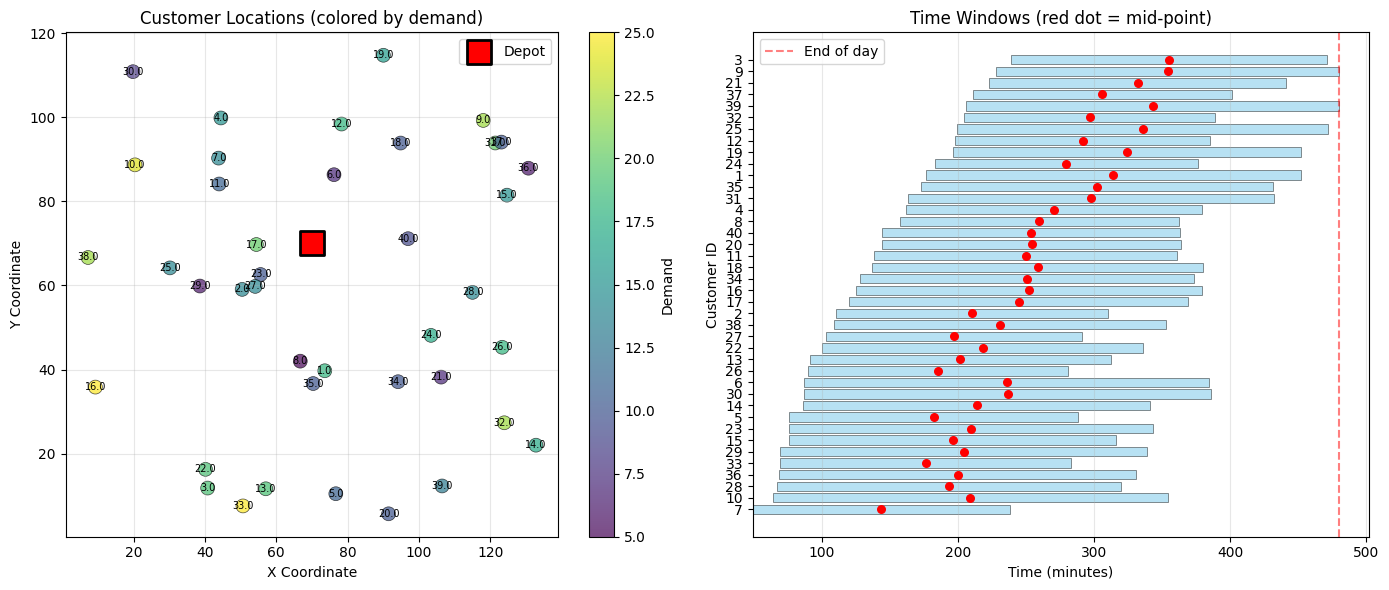

Intermediate dataset: 


⚙️ Adjusting vehicles from 10 → 16 to achieve ~65% utilization.

 Dataset Statistics:
  Customers: 100
  Vehicles: 16
  Vehicle capacity: 150
  Total demand: 1496.0
  Fleet capacity: 2400
  Utilization: 62.3% (target: 65%)
  Average demand per customer: 15.0
  Average time window width: 300.9 minutes
  Depot operating window: 0–720 min (12.0 hours)

  Time of day distribution:
    Morning (0–2h): 26
    Midday (2–4h): 65
    Afternoon (4h+): 9

  Window flexibility:
    Tight (<2h): 0
    Moderate (2–3h): 0
    Flexible (≥3h): 100

 Visualization saved to vrptw_medium_visualization.png


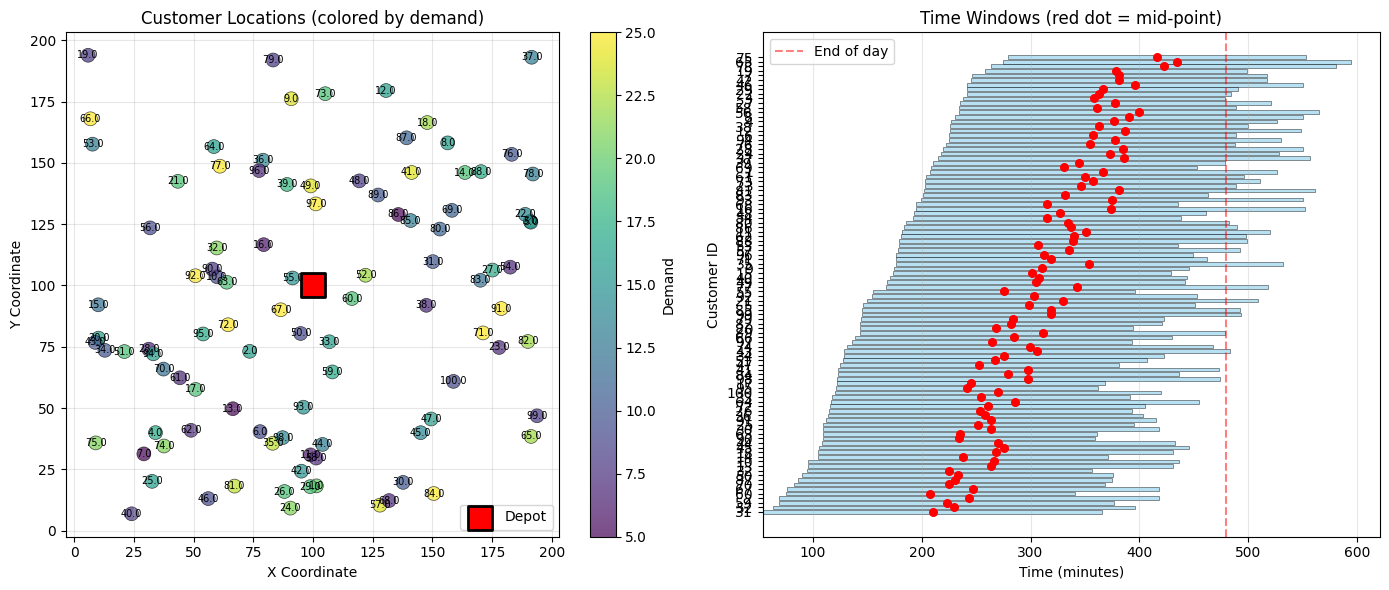

Advanced dataset: 


⚙️ Adjusting vehicles from 25 → 38 to achieve ~65% utilization.

 Dataset Statistics:
  Customers: 250
  Vehicles: 38
  Vehicle capacity: 150
  Total demand: 3676.0
  Fleet capacity: 5700
  Utilization: 64.5% (target: 65%)
  Average demand per customer: 14.7
  Average time window width: 390.0 minutes
  Depot operating window: 0–1080 min (18.0 hours)

  Time of day distribution:
    Morning (0–2h): 18
    Midday (2–4h): 141
    Afternoon (4h+): 91

  Window flexibility:
    Tight (<2h): 0
    Moderate (2–3h): 0
    Flexible (≥3h): 250

 Visualization saved to vrptw_hard_visualization.png


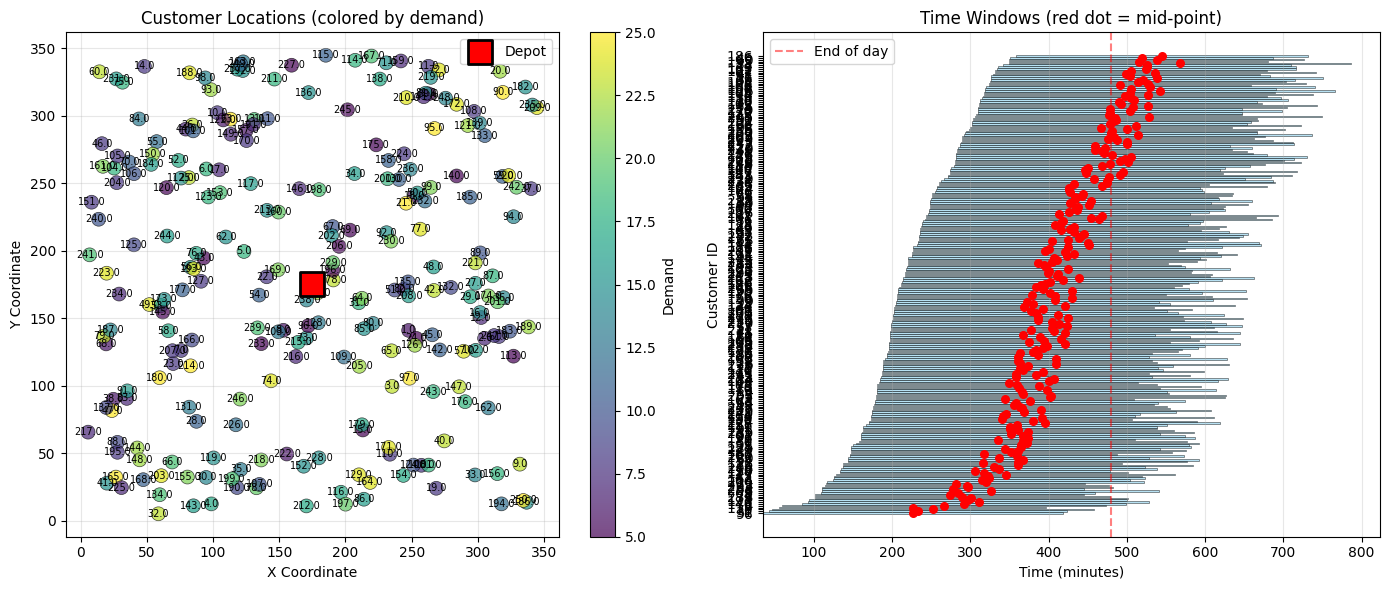

Feasibility check: 


1. CAPACITY CHECK:
   Total demand: 584
   Fleet capacity: 1000
   Utilization: 58.4%
   Capacity is sufficient

2. TIME WINDOW CHECK:
   All customers have feasible time windows

3. GEOGRAPHIC DISTRIBUTION:
   Average distance from depot: 46.68
   Max distance from depot: 78.99
   Min distance from depot: 15.59
Feasibility check: 


1. CAPACITY CHECK:
   Total demand: 1496
   Fleet capacity: 2400
   Utilization: 62.3%
   Capacity is sufficient

2. TIME WINDOW CHECK:
   All customers have feasible time windows

3. GEOGRAPHIC DISTRIBUTION:
   Average distance from depot: 71.58
   Max distance from depot: 133.01
   Min distance from depot: 9.09
Feasibility check: 


1. CAPACITY CHECK:
   Total demand: 3676
   Fleet capacity: 5700
   Utilization: 64.5%
   Capacity is sufficient

2. TIME WINDOW CHECK:
   All customers have feasible time windows

3. GEOGRAPHIC DISTRIBUTION:
   Average distance from depot: 132.37
   Max distance from depot: 228.48
   Min distance from d

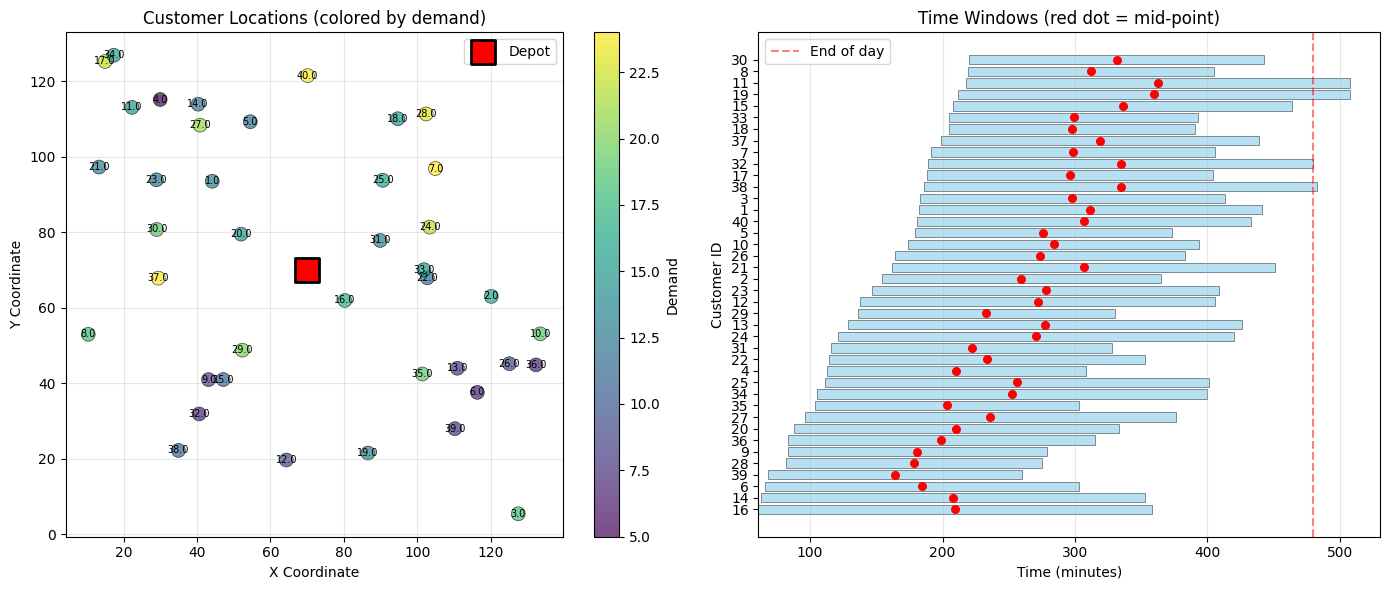

Intermediate dataset: 


⚙️ Adjusting vehicles from 10 → 16 to achieve ~65% utilization.

 Dataset Statistics:
  Customers: 100
  Vehicles: 16
  Vehicle capacity: 150
  Total demand: 1486.0
  Fleet capacity: 2400
  Utilization: 61.9% (target: 65%)
  Average demand per customer: 14.9
  Average time window width: 303.1 minutes
  Depot operating window: 0–720 min (12.0 hours)

  Time of day distribution:
    Morning (0–2h): 24
    Midday (2–4h): 68
    Afternoon (4h+): 8

  Window flexibility:
    Tight (<2h): 0
    Moderate (2–3h): 0
    Flexible (≥3h): 100

 Visualization saved to vrptw_medium_visualization.png


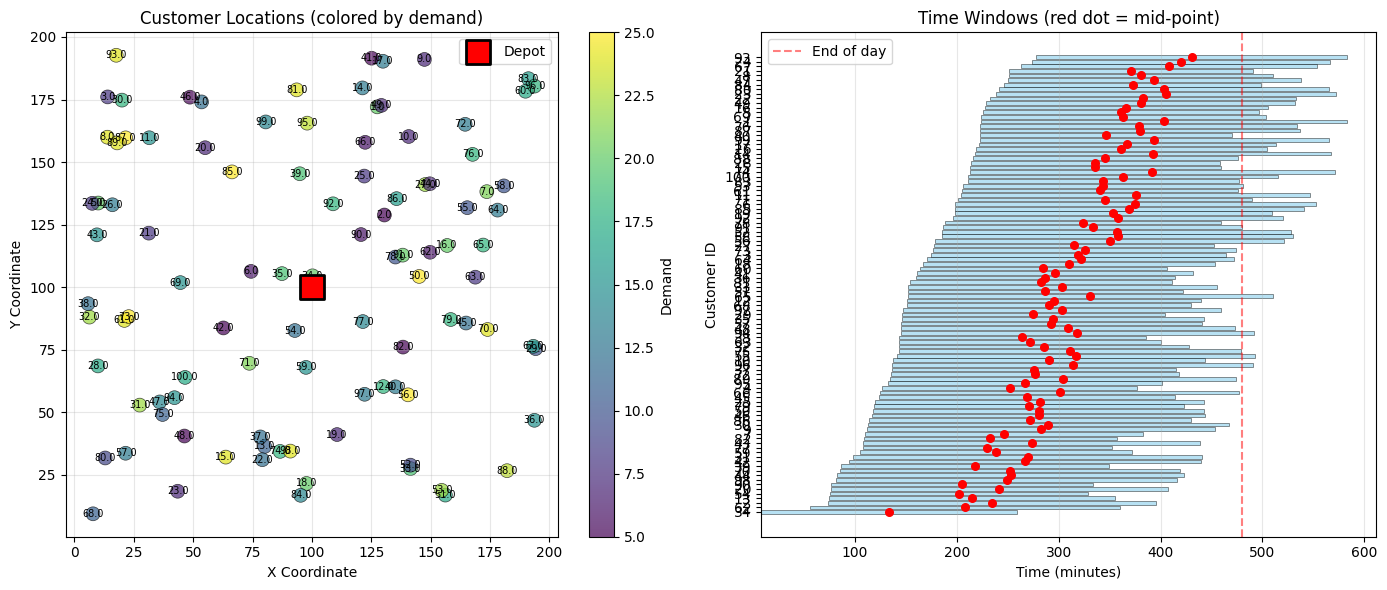

Advanced dataset: 


⚙️ Adjusting vehicles from 25 → 39 to achieve ~65% utilization.

 Dataset Statistics:
  Customers: 250
  Vehicles: 39
  Vehicle capacity: 150
  Total demand: 3717.0
  Fleet capacity: 5850
  Utilization: 63.5% (target: 65%)
  Average demand per customer: 14.9
  Average time window width: 393.0 minutes
  Depot operating window: 0–1080 min (18.0 hours)

  Time of day distribution:
    Morning (0–2h): 26
    Midday (2–4h): 116
    Afternoon (4h+): 108

  Window flexibility:
    Tight (<2h): 0
    Moderate (2–3h): 0
    Flexible (≥3h): 250

 Visualization saved to vrptw_hard_visualization.png


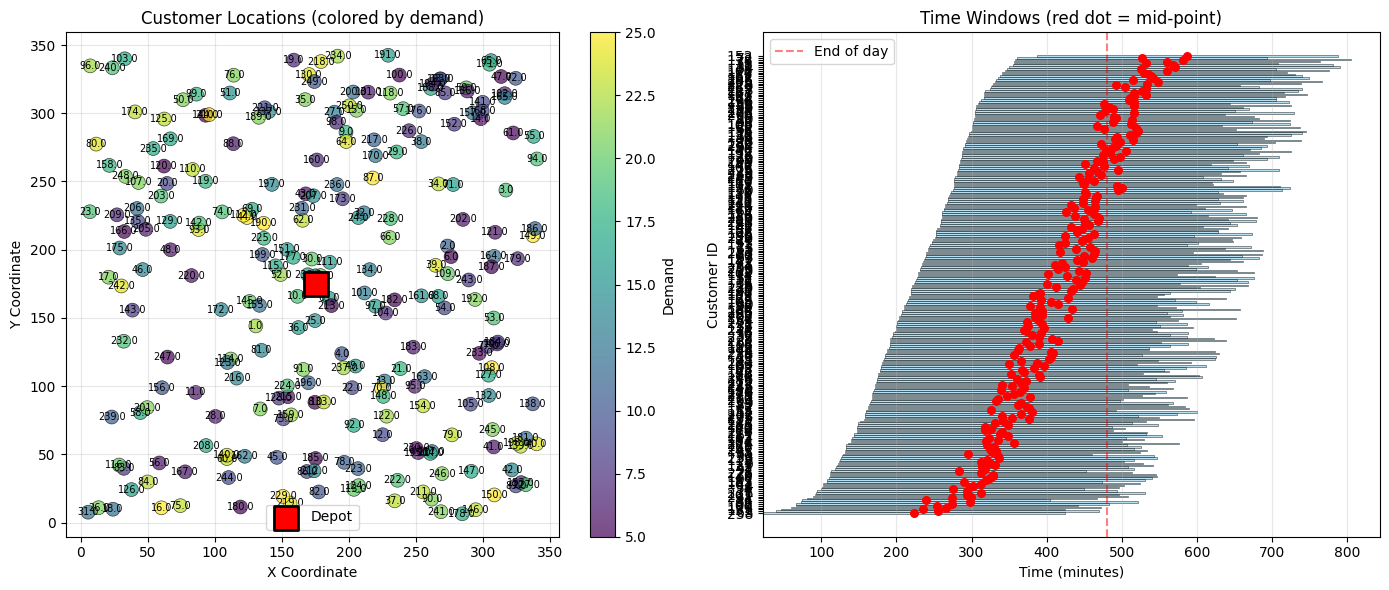

Feasibility check: 


1. CAPACITY CHECK:
   Total demand: 588
   Fleet capacity: 1000
   Utilization: 58.8%
   Capacity is sufficient

2. TIME WINDOW CHECK:
   All customers have feasible time windows

3. GEOGRAPHIC DISTRIBUTION:
   Average distance from depot: 48.63
   Max distance from depot: 86.51
   Min distance from depot: 13.06
Feasibility check: 


1. CAPACITY CHECK:
   Total demand: 1486
   Fleet capacity: 2400
   Utilization: 61.9%
   Capacity is sufficient

2. TIME WINDOW CHECK:
   All customers have feasible time windows

3. GEOGRAPHIC DISTRIBUTION:
   Average distance from depot: 74.83
   Max distance from depot: 129.30
   Min distance from depot: 4.51
Feasibility check: 


1. CAPACITY CHECK:
   Total demand: 3717
   Fleet capacity: 5850
   Utilization: 63.5%
   Capacity is sufficient

2. TIME WINDOW CHECK:
   All customers have feasible time windows

3. GEOGRAPHIC DISTRIBUTION:
   Average distance from depot: 129.79
   Max distance from depot: 238.26
   Min distance from d

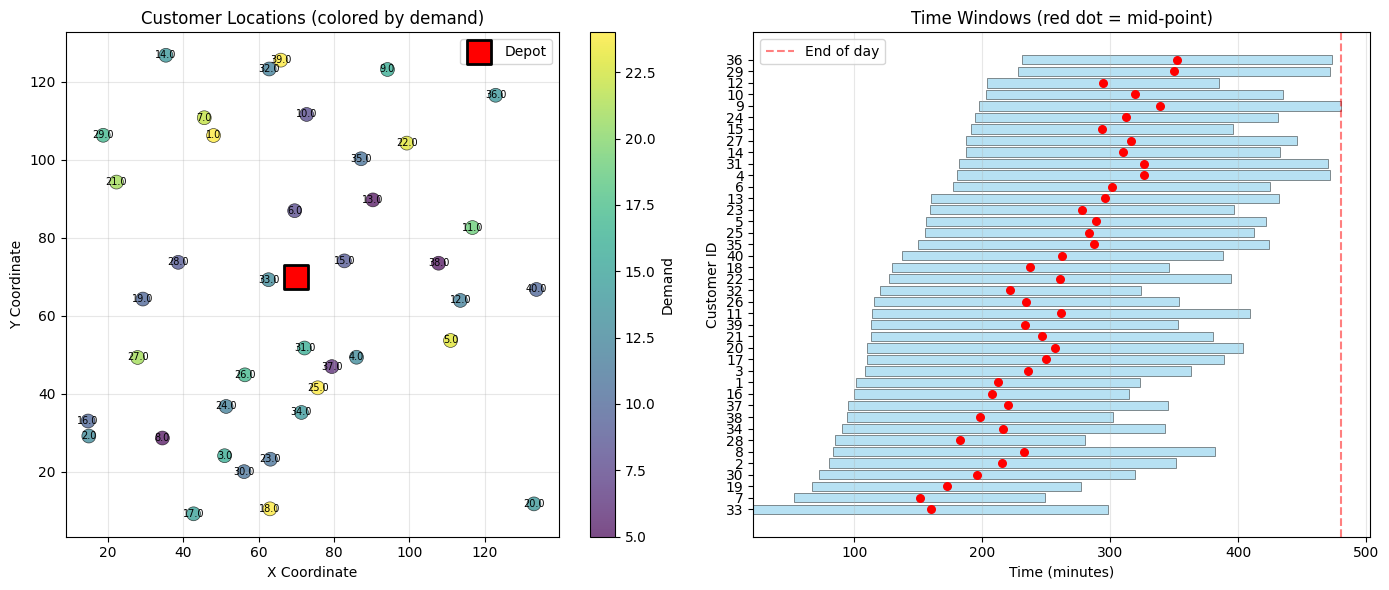

Intermediate dataset: 


⚙️ Adjusting vehicles from 10 → 16 to achieve ~65% utilization.

 Dataset Statistics:
  Customers: 100
  Vehicles: 16
  Vehicle capacity: 150
  Total demand: 1474.0
  Fleet capacity: 2400
  Utilization: 61.4% (target: 65%)
  Average demand per customer: 14.7
  Average time window width: 296.0 minutes
  Depot operating window: 0–720 min (12.0 hours)

  Time of day distribution:
    Morning (0–2h): 24
    Midday (2–4h): 62
    Afternoon (4h+): 14

  Window flexibility:
    Tight (<2h): 0
    Moderate (2–3h): 0
    Flexible (≥3h): 100

 Visualization saved to vrptw_medium_visualization.png


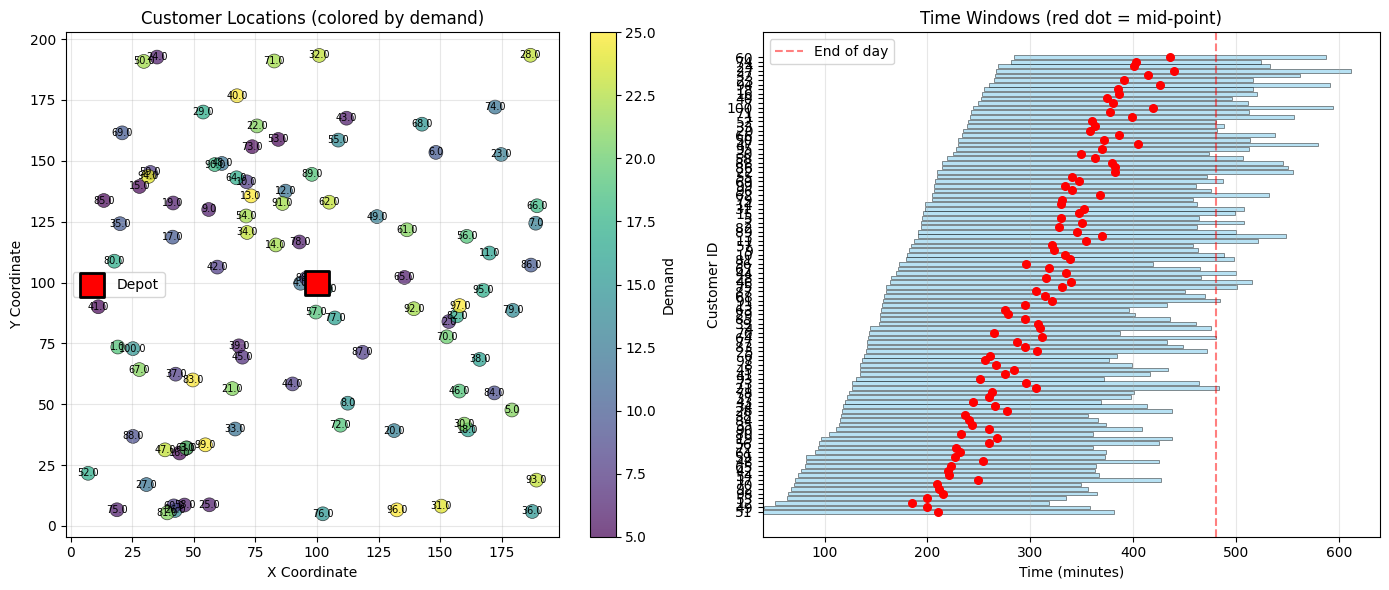

Advanced dataset: 


⚙️ Adjusting vehicles from 25 → 38 to achieve ~65% utilization.

 Dataset Statistics:
  Customers: 250
  Vehicles: 38
  Vehicle capacity: 150
  Total demand: 3652.0
  Fleet capacity: 5700
  Utilization: 64.1% (target: 65%)
  Average demand per customer: 14.6
  Average time window width: 391.6 minutes
  Depot operating window: 0–1080 min (18.0 hours)

  Time of day distribution:
    Morning (0–2h): 15
    Midday (2–4h): 130
    Afternoon (4h+): 105

  Window flexibility:
    Tight (<2h): 0
    Moderate (2–3h): 0
    Flexible (≥3h): 250

 Visualization saved to vrptw_hard_visualization.png


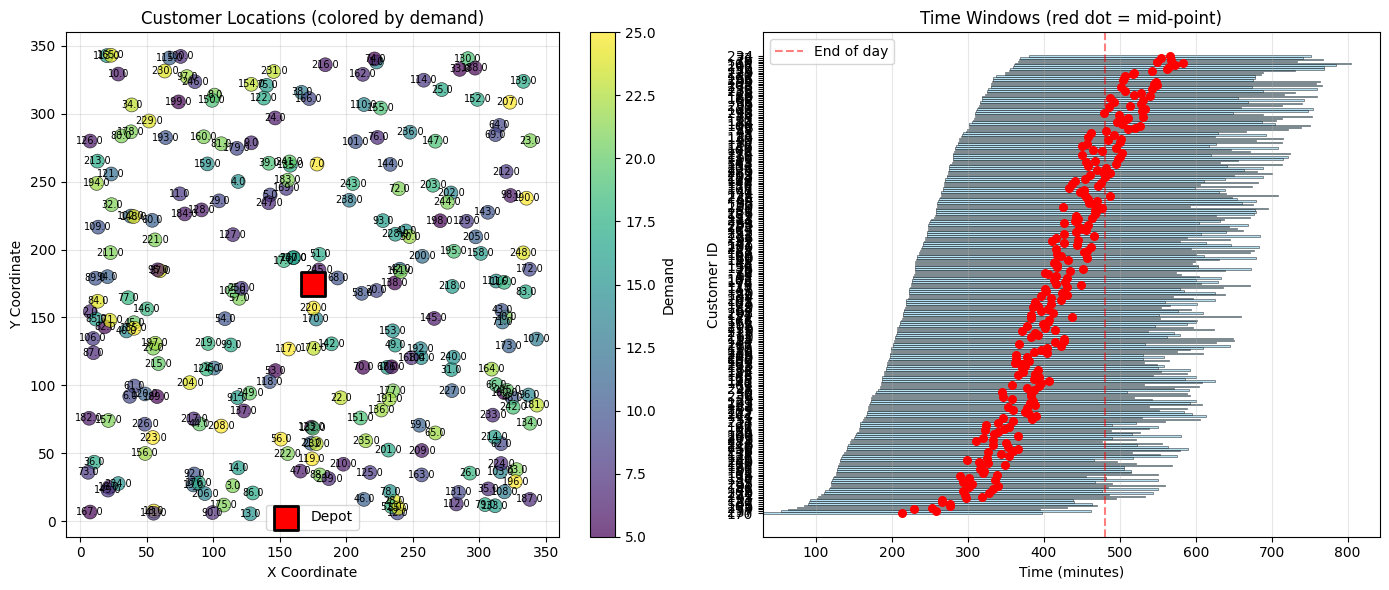

Feasibility check: 


1. CAPACITY CHECK:
   Total demand: 571
   Fleet capacity: 1000
   Utilization: 57.1%
   Capacity is sufficient

2. TIME WINDOW CHECK:
   All customers have feasible time windows

3. GEOGRAPHIC DISTRIBUTION:
   Average distance from depot: 45.18
   Max distance from depot: 85.84
   Min distance from depot: 7.41
Feasibility check: 


1. CAPACITY CHECK:
   Total demand: 1474
   Fleet capacity: 2400
   Utilization: 61.4%
   Capacity is sufficient

2. TIME WINDOW CHECK:
   All customers have feasible time windows

3. GEOGRAPHIC DISTRIBUTION:
   Average distance from depot: 71.27
   Max distance from depot: 128.40
   Min distance from depot: 4.28
Feasibility check: 


1. CAPACITY CHECK:
   Total demand: 3652
   Fleet capacity: 5700
   Utilization: 64.1%
   Capacity is sufficient

2. TIME WINDOW CHECK:
   All customers have feasible time windows

3. GEOGRAPHIC DISTRIBUTION:
   Average distance from depot: 137.74
   Max distance from depot: 237.35
   Min distance from de

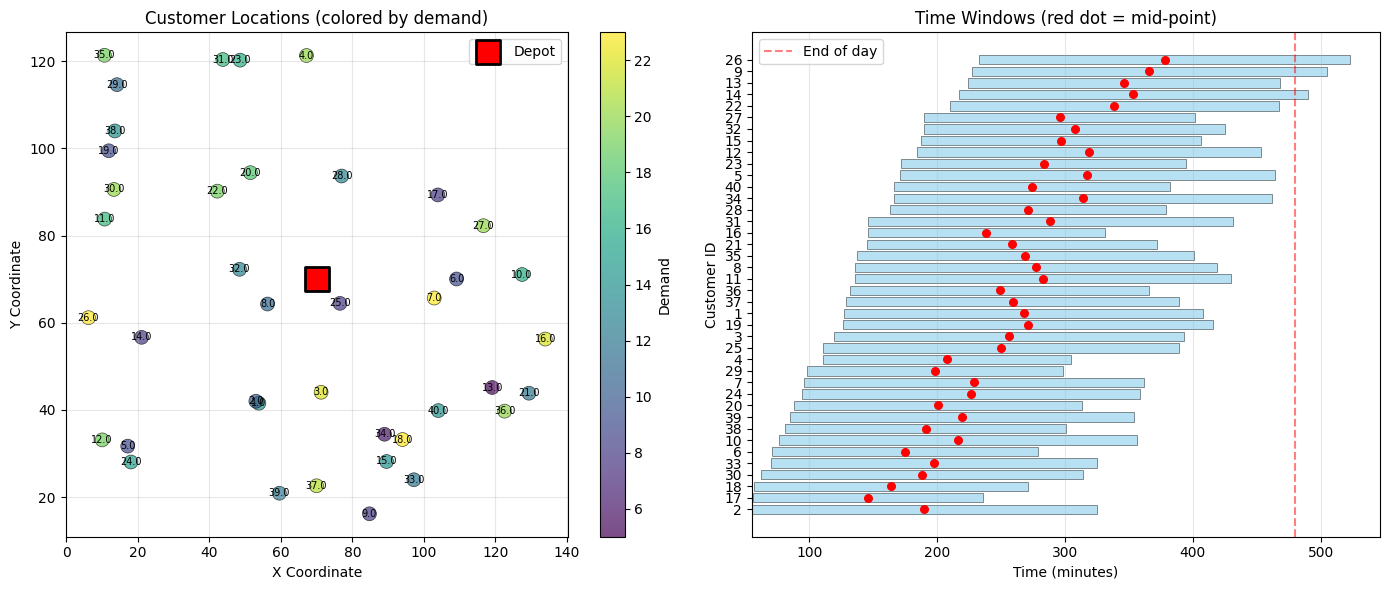

Intermediate dataset: 


⚙️ Adjusting vehicles from 10 → 16 to achieve ~65% utilization.

 Dataset Statistics:
  Customers: 100
  Vehicles: 16
  Vehicle capacity: 150
  Total demand: 1538.0
  Fleet capacity: 2400
  Utilization: 64.1% (target: 65%)
  Average demand per customer: 15.4
  Average time window width: 303.4 minutes
  Depot operating window: 0–720 min (12.0 hours)

  Time of day distribution:
    Morning (0–2h): 27
    Midday (2–4h): 60
    Afternoon (4h+): 13

  Window flexibility:
    Tight (<2h): 0
    Moderate (2–3h): 0
    Flexible (≥3h): 100

 Visualization saved to vrptw_medium_visualization.png


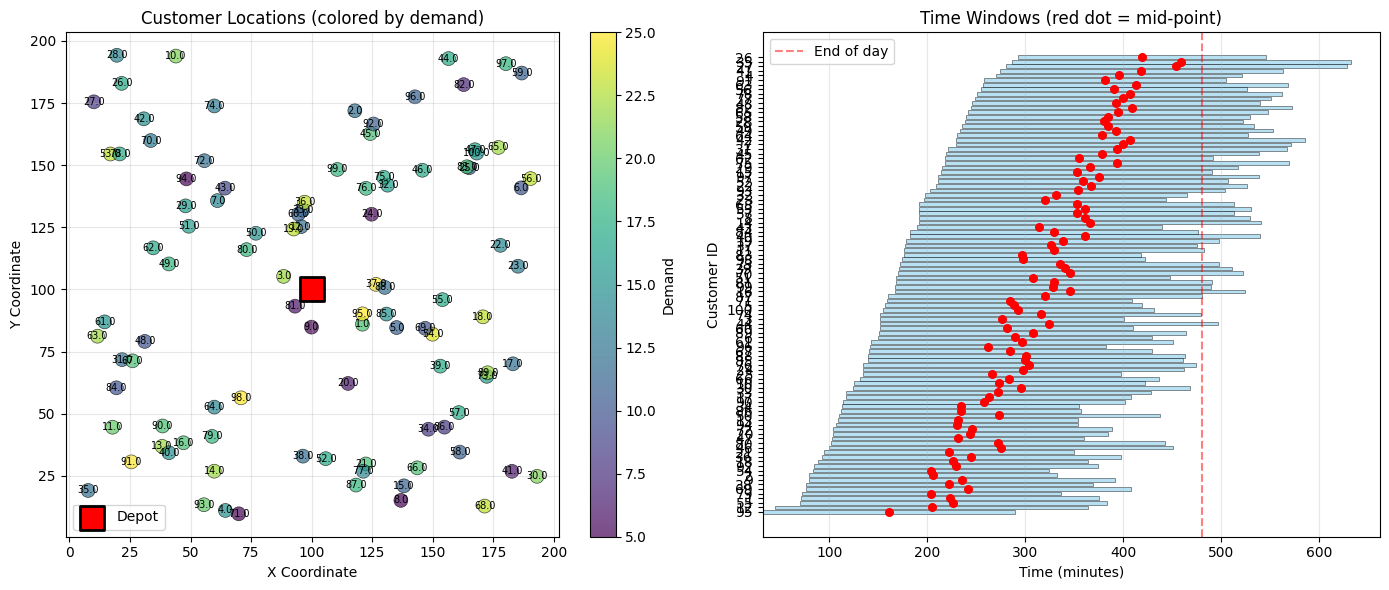

Advanced dataset: 


⚙️ Adjusting vehicles from 25 → 40 to achieve ~65% utilization.

 Dataset Statistics:
  Customers: 250
  Vehicles: 40
  Vehicle capacity: 150
  Total demand: 3808.0
  Fleet capacity: 6000
  Utilization: 63.5% (target: 65%)
  Average demand per customer: 15.2
  Average time window width: 393.1 minutes
  Depot operating window: 0–1080 min (18.0 hours)

  Time of day distribution:
    Morning (0–2h): 18
    Midday (2–4h): 142
    Afternoon (4h+): 90

  Window flexibility:
    Tight (<2h): 0
    Moderate (2–3h): 0
    Flexible (≥3h): 250

 Visualization saved to vrptw_hard_visualization.png


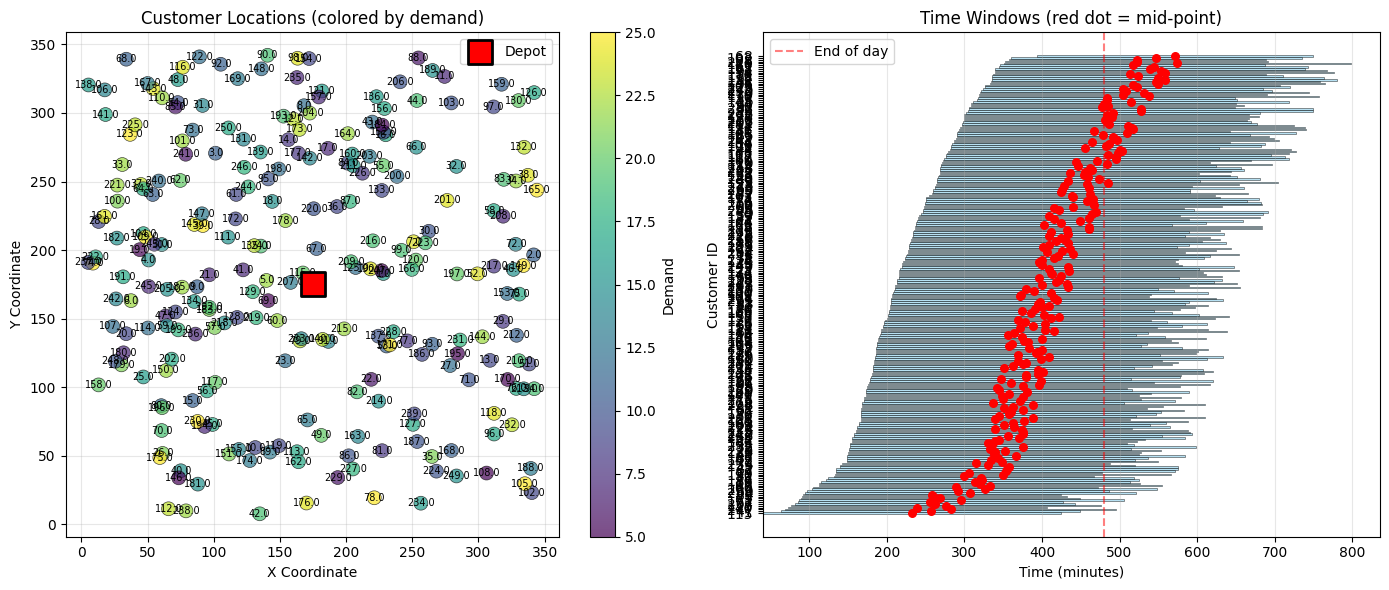

Feasibility check: 


1. CAPACITY CHECK:
   Total demand: 590
   Fleet capacity: 1000
   Utilization: 59.0%
   Capacity is sufficient

2. TIME WINDOW CHECK:
   All customers have feasible time windows

3. GEOGRAPHIC DISTRIBUTION:
   Average distance from depot: 48.87
   Max distance from depot: 78.49
   Min distance from depot: 8.54
Feasibility check: 


1. CAPACITY CHECK:
   Total demand: 1538
   Fleet capacity: 2400
   Utilization: 64.1%
   Capacity is sufficient

2. TIME WINDOW CHECK:
   All customers have feasible time windows

3. GEOGRAPHIC DISTRIBUTION:
   Average distance from depot: 73.05
   Max distance from depot: 123.87
   Min distance from depot: 9.62
Feasibility check: 


1. CAPACITY CHECK:
   Total demand: 3808
   Fleet capacity: 6000
   Utilization: 63.5%
   Capacity is sufficient

2. TIME WINDOW CHECK:
   All customers have feasible time windows

3. GEOGRAPHIC DISTRIBUTION:
   Average distance from depot: 127.36
   Max distance from depot: 224.58
   Min distance from de

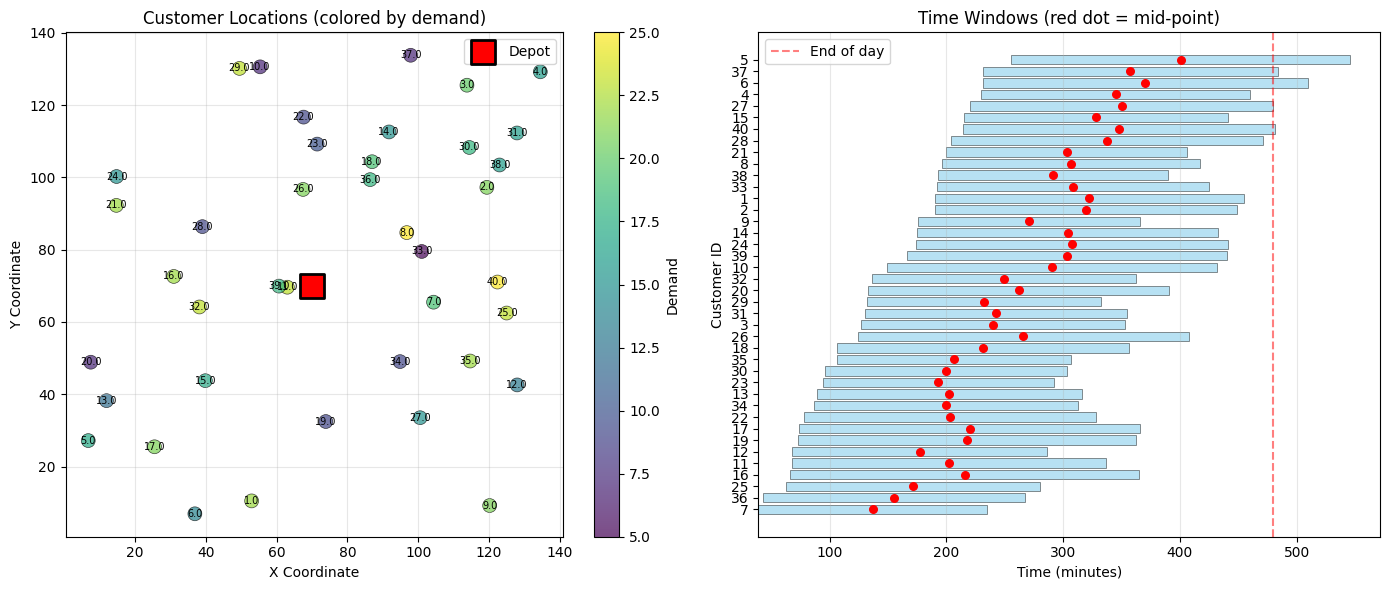

Intermediate dataset: 


⚙️ Adjusting vehicles from 10 → 17 to achieve ~65% utilization.

 Dataset Statistics:
  Customers: 100
  Vehicles: 17
  Vehicle capacity: 150
  Total demand: 1594.0
  Fleet capacity: 2550
  Utilization: 62.5% (target: 65%)
  Average demand per customer: 15.9
  Average time window width: 303.1 minutes
  Depot operating window: 0–720 min (12.0 hours)

  Time of day distribution:
    Morning (0–2h): 18
    Midday (2–4h): 71
    Afternoon (4h+): 11

  Window flexibility:
    Tight (<2h): 0
    Moderate (2–3h): 0
    Flexible (≥3h): 100

 Visualization saved to vrptw_medium_visualization.png


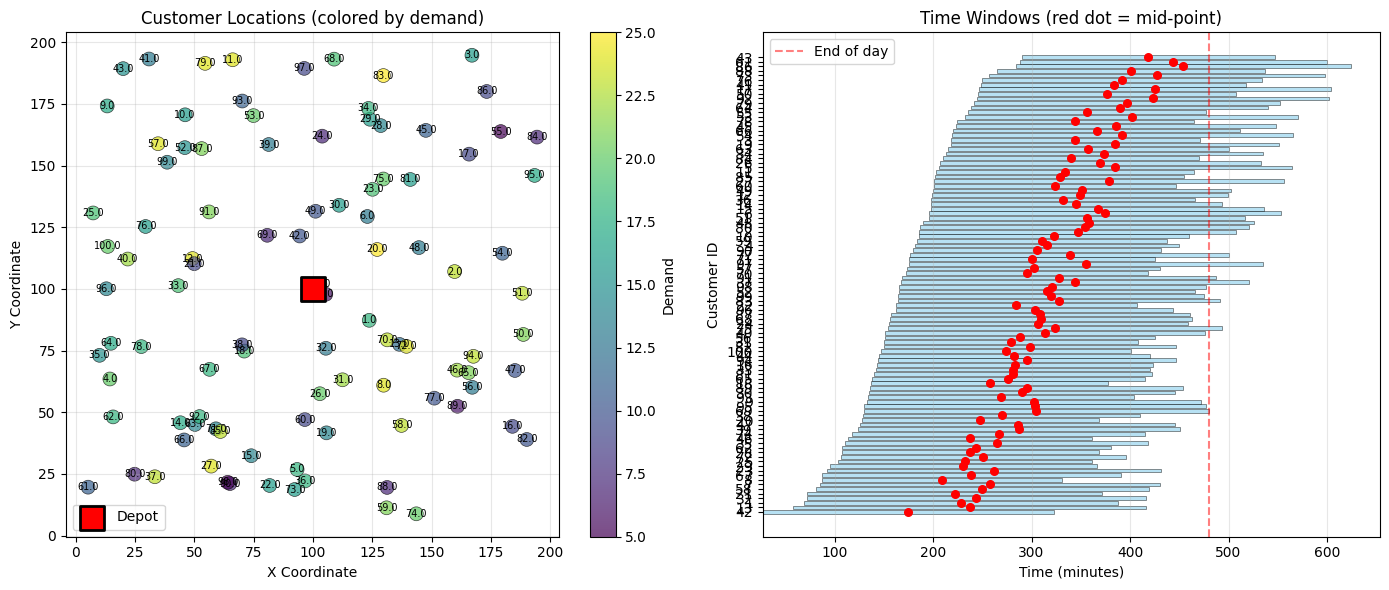

Advanced dataset: 


⚙️ Adjusting vehicles from 25 → 40 to achieve ~65% utilization.

 Dataset Statistics:
  Customers: 250
  Vehicles: 40
  Vehicle capacity: 150
  Total demand: 3894.0
  Fleet capacity: 6000
  Utilization: 64.9% (target: 65%)
  Average demand per customer: 15.6
  Average time window width: 394.7 minutes
  Depot operating window: 0–1080 min (18.0 hours)

  Time of day distribution:
    Morning (0–2h): 26
    Midday (2–4h): 129
    Afternoon (4h+): 95

  Window flexibility:
    Tight (<2h): 0
    Moderate (2–3h): 0
    Flexible (≥3h): 250

 Visualization saved to vrptw_hard_visualization.png


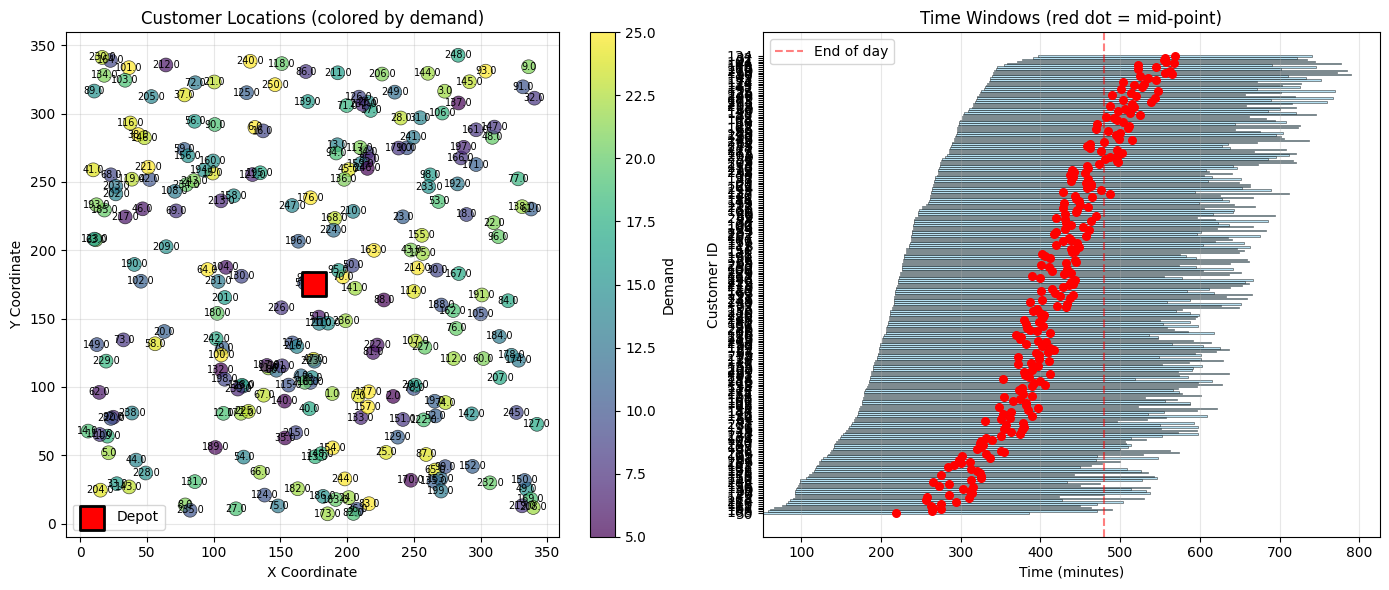

Feasibility check: 


1. CAPACITY CHECK:
   Total demand: 664
   Fleet capacity: 1200
   Utilization: 55.3%
   Capacity is sufficient

2. TIME WINDOW CHECK:
   All customers have feasible time windows

3. GEOGRAPHIC DISTRIBUTION:
   Average distance from depot: 51.01
   Max distance from depot: 87.52
   Min distance from depot: 6.96
Feasibility check: 


1. CAPACITY CHECK:
   Total demand: 1594
   Fleet capacity: 2550
   Utilization: 62.5%
   Capacity is sufficient

2. TIME WINDOW CHECK:
   All customers have feasible time windows

3. GEOGRAPHIC DISTRIBUTION:
   Average distance from depot: 73.17
   Max distance from depot: 124.24
   Min distance from depot: 3.47
Feasibility check: 


1. CAPACITY CHECK:
   Total demand: 3894
   Fleet capacity: 6000
   Utilization: 64.9%
   Capacity is sufficient

2. TIME WINDOW CHECK:
   All customers have feasible time windows

3. GEOGRAPHIC DISTRIBUTION:
   Average distance from depot: 129.85
   Max distance from depot: 231.70
   Min distance from de

In [12]:
synthetic_results = []

for i in range(0,5):
    temp_results=[]
    
    generated_datasets = generate_multiple_datasets()
    easy_graph = generated_datasets['easy']
    intermediate_graph = generated_datasets['medium']
    advanced_graph = generated_datasets['hard']
    solution1, solve_time1 = ortools(easy_graph[0], easy_graph[1], time_limit_seconds=60, verbose=False)
    temp_results.append({
        'instance': f'easy_{i}',
        'solved': solution1 is not None,
        'time': solve_time1
    })
    solution2, solve_time2 = ortools(intermediate_graph[0], intermediate_graph[1], time_limit_seconds=60, verbose=False)
    temp_results.append({
        'instance': f'medium_{i}',
        'solved': solution2 is not None,
        'time': solve_time2
    })
    solution3, solve_time3 = ortools(advanced_graph[0], advanced_graph[1], time_limit_seconds=60, verbose=False)
    temp_results.append({
        'instance': f'advanced_{i}',
        'solved': solution3 is not None,
        'time': solve_time3
    })
    synthetic_results.append(temp_results)
    


In [13]:
count_true = 0
count_false = 0
for sublist in synthetic_results:
    for entry in sublist:
        if entry['solved'] == True:
            count_true += 1
        if entry['solved'] == False:
            count_false += 1

print(f"Number of solved graphs is {count_true}")
print(f"Accuracy over 5 iterations of generated instances is {count_true/(count_true+count_false) *100} %")

Number of solved graphs is 15
Accuracy over 5 iterations of generated instances is 100.0 %


## MILP Solver

In [22]:
def solve_vrptw_milp(df, vehicle_info, time_limit=300):
    import pulp
    import time
    
    start_time = time.time()
    
    n = len(df)
    K = vehicle_info['n_vehicles']
    
    num_vars = n * n * K + n * K
    print(f"\nMILP Problem Size:")
    print(f"  Customers: {n-1}")
    print(f"  Binary variables: {n*n*K:,}")
    print(f"  Total variables: {num_vars:,}")
    
    if n > 15:
        print(f"\n  WARNING: MILP is TOO SLOW for {n-1} customers!")
    
    print(f"\nBuilding MILP model...")
    
    prob = pulp.LpProblem("VRPTW", pulp.LpMinimize)
    locations = df[['x', 'y']].values
    dist = {}
    for i in range(n):
        for j in range(n):
            if i != j:
                dx = locations[i][0] - locations[j][0]
                dy = locations[i][1] - locations[j][1]
                dist[i,j] = np.sqrt(dx**2 + dy**2)
    
    x = {}
    for i in range(n):
        for j in range(n):
            for k in range(K):
                if i != j:
                    x[i,j,k] = pulp.LpVariable(f"x_{i}_{j}_{k}", cat='Binary')
    
    t = {}
    max_time = int(df['due_time'].max())
    for i in range(n):
        for k in range(K):
            t[i,k] = pulp.LpVariable(f"t_{i}_{k}", lowBound=0, upBound=max_time)
    
    prob += pulp.lpSum([dist[i,j] * x[i,j,k] 
                        for i in range(n) for j in range(n) for k in range(K) if i != j])
    
    for i in range(1, n):
        prob += pulp.lpSum([x[i,j,k] for j in range(n) for k in range(K) if i != j]) == 1
    
    for i in range(n):
        for k in range(K):
            prob += pulp.lpSum([x[i,j,k] for j in range(n) if i != j]) == \
                    pulp.lpSum([x[j,i,k] for j in range(n) if i != j])
    
    for k in range(K):
        prob += pulp.lpSum([x[0,j,k] for j in range(1, n)]) <= 1
    
    demand = df['demand'].values
    capacity = vehicle_info['vehicle_capacity']
    for k in range(K):
        prob += pulp.lpSum([demand[i] * x[i,j,k] 
                           for i in range(1, n) for j in range(n) if i != j]) <= capacity
    
    ready = df['ready_time'].values
    due = df['due_time'].values
    service = df['service_time'].values
    M = max_time * 3 
    
    for i in range(n):
        for k in range(K):
            prob += t[i,k] >= ready[i]
            prob += t[i,k] <= due[i]
    
    for k in range(K):
        prob += t[0,k] == 0
    
    for i in range(n):
        for j in range(n):
            for k in range(K):
                if i != j:
                    prob += t[j,k] >= t[i,k] + service[i] + dist[i,j] - M * (1 - x[i,j,k])
    
    u = {}
    for i in range(1, n):
        for k in range(K):
            u[i,k] = pulp.LpVariable(f"u_{i}_{k}", lowBound=1, upBound=n)
    
    for i in range(1, n):
        for j in range(1, n):
            for k in range(K):
                if i != j:
                    prob += u[i,k] - u[j,k] + n * x[i,j,k] <= n - 1
    
    print(f"Solving with time limit {time_limit}s...")
    solver = pulp.PULP_CBC_CMD(timeLimit=time_limit, msg=1)
    prob.solve(solver)
    solve_time = time.time() - start_time
    status_name = pulp.LpStatus[prob.status]
    
    if prob.status == pulp.LpStatusOptimal or prob.status == 1:
        print(f"\n✅ Solution found!")
        print(f"  Status: {status_name}")
        print(f"  Objective: {pulp.value(prob.objective):.2f}")
        print(f"  Solve time: {solve_time:.2f}s")
        
        routes = []
        for k in range(K):
            route = [0]
            current = 0
            visited = {0}
            
            while True:
                next_node = None
                for j in range(n):
                    if j not in visited and current != j: 
                        if (current,j,k) in x and pulp.value(x[current,j,k]) > 0.5:
                            next_node = j
                            break
                
                if next_node is None:
                    break
                
                route.append(next_node)
                visited.add(next_node)
                current = next_node
            
            if len(route) > 1:
                route.append(0)
                route_dist = sum(dist[route[i], route[i+1]] for i in range(len(route)-1))
                routes.append({
                    'vehicle_id': k,
                    'route': route,
                    'distance': route_dist
                })
        
        return {
            'routes': routes,
            'total_distance': pulp.value(prob.objective),
            'solve_time': solve_time,
            'status': status_name,
            'num_vehicles_used': len(routes)
        }, solve_time
    
    else:
        print(f"\n✗ No solution found or timeout")
        print(f"  Status: {status_name}")
        print(f"  Time: {solve_time:.2f}s")
        return None, solve_time

In [23]:
solve_vrptw_milp(easy_graph[0],easy_graph[1])


MILP Problem Size:
  Customers: 40
  Binary variables: 8,405
  Total variables: 8,610


Building MILP model...
Solving with time limit 300s...

✗ No solution found or timeout
  Status: Not Solved
  Time: 300.01s


(None, 300.0067126750946)

## Simulated annealing appoach

In [24]:
import numpy as np
import time
from copy import deepcopy

class SimulatedAnnealingVRPTW:
    def __init__(self, df, vehicle_info):
        self.df = df.reset_index(drop=True)
        self.n = len(df)
        self.K = vehicle_info['n_vehicles']
        self.capacity = vehicle_info['vehicle_capacity']
        
        locations = df[['x', 'y']].values
        self.demands = df['demand'].values
        self.ready_times = df['ready_time'].values
        self.due_times = df['due_time'].values
        self.service_times = df['service_time'].values
        
        self.distances = np.zeros((self.n, self.n))
        for i in range(self.n):
            for j in range(self.n):
                if i != j:
                    dx = locations[i][0] - locations[j][0]
                    dy = locations[i][1] - locations[j][1]
                    self.distances[i][j] = np.sqrt(dx**2 + dy**2)
        self.alpha_capacity = 500
        self.alpha_time = 10
    
    def _create_initial_solution(self):
        unvisited = set(range(1, self.n))
        routes = []
        for k in range(self.K):
            route = [0]
            current = 0
            current_time = 0
            current_load = 0
            
            while unvisited:
                best = None
                best_dist = float('inf')
                
                for customer in list(unvisited):
                    if current_load + self.demands[customer] > self.capacity:
                        continue
                    
                    dist = self.distances[current][customer]
                    if dist < best_dist:
                        best_dist = dist
                        best = customer
                
                if best is None:
                    break
                
                route.append(best)
                current_load += self.demands[best]
                travel_time = self.distances[current][best]
                arrival = current_time + travel_time
                current_time = max(arrival, self.ready_times[best]) + self.service_times[best]
                
                current = best
                unvisited.remove(best)
            
            route.append(0)
            routes.append(route)
        
        if unvisited:
            remaining = list(unvisited)
            for i, customer in enumerate(remaining):
                vehicle_idx = i % self.K
                routes[vehicle_idx].insert(-1, customer)
        
        return routes
    
    def _calculate_capacity_violation(self, route):
        if len(route) <= 2:
            return 0.0
        
        used_capacity = sum(self.demands[c] for c in route[1:-1])
        
        if used_capacity > self.capacity:
            return used_capacity - self.capacity
        return 0.0
    
    def _calculate_time_violation(self, route):
        if len(route) <= 2:
            return 0.0
        
        total_violation = 0.0
        current_time = 0.0
        
        for i in range(len(route) - 1):
            current = route[i]
            next_node = route[i + 1]
            current_time += self.distances[current][next_node]
            if next_node == 0:
                continue
            arrival_time = current_time
            ready = self.ready_times[next_node]
            due = self.due_times[next_node]
            
            if arrival_time > due:
                violation = arrival_time - due
                total_violation += violation
                current_time = arrival_time + self.service_times[next_node]
            elif arrival_time < ready:
                current_time = ready + self.service_times[next_node]
            else:
                current_time = arrival_time + self.service_times[next_node]
        
        return total_violation
    
    def _calculate_route_distance(self, route):
        return sum(self.distances[route[i]][route[i+1]] 
                  for i in range(len(route) - 1))
    
    def _calculate_cost(self, routes):
        total_distance = 0.0
        total_capacity_violation = 0.0
        total_time_violation = 0.0
        
        for route in routes:
            total_distance += self._calculate_route_distance(route)
            total_capacity_violation += self._calculate_capacity_violation(route)
            total_time_violation += self._calculate_time_violation(route)
        
        cost = (total_distance + 
                self.alpha_capacity * total_capacity_violation +
                self.alpha_time * total_time_violation)
        
        return cost, total_distance, total_capacity_violation, total_time_violation
    
    def _swap_operator(self, routes):
        new_routes = deepcopy(routes)
        route_idx = np.random.randint(0, len(new_routes))
        route = new_routes[route_idx]
        
        if len(route) <= 3:
            return new_routes
        
        pos1, pos2 = np.random.choice(range(1, len(route) - 1), 2, replace=False)
        route[pos1], route[pos2] = route[pos2], route[pos1]
        
        return new_routes
    
    def _reversion_operator(self, routes):
        new_routes = deepcopy(routes)
        route_idx = np.random.randint(0, len(new_routes))
        route = new_routes[route_idx]
        
        if len(route) <= 3:
            return new_routes
        
        i, j = sorted(np.random.choice(range(1, len(route) - 1), 2, replace=False))
        route[i:j+1] = list(reversed(route[i:j+1]))
        
        return new_routes
    
    def _insertion_operator(self, routes):
        new_routes = deepcopy(routes)
        
        source_idx = np.random.randint(0, len(new_routes))
        source_route = new_routes[source_idx]
        
        if len(source_route) <= 2:
            return new_routes
        
        customer_pos = np.random.randint(1, len(source_route) - 1)
        customer = source_route.pop(customer_pos)
        
        dest_idx = np.random.randint(0, len(new_routes))
        dest_route = new_routes[dest_idx]
        
        insert_pos = np.random.randint(1, len(dest_route))
        dest_route.insert(insert_pos, customer)
        
        return new_routes
    
    def _get_neighbor(self, routes):
        operator = np.random.choice([0, 1, 2], p=[0.4, 0.3, 0.3])
        
        if operator == 0:
            return self._swap_operator(routes)
        elif operator == 1:
            return self._reversion_operator(routes)
        else:
            return self._insertion_operator(routes)
    
    def solve(self, initial_temp=1000, cooling_rate=0.995, 
              min_temp=0.01, max_iterations=50000, verbose=True):
        start_time = time.time()
        
        if verbose:
            print(f"Problem: {self.n-1} customers, {self.K} vehicles")
            print(f"Capacity: {self.capacity}, Total demand: {sum(self.demands):.0f}")
            print(f"Penalties: α_capacity={self.alpha_capacity}, α_time={self.alpha_time}")
            print("="*70)
        
        current_routes = self._create_initial_solution()
        current_cost, current_dist, current_cv, current_tw = self._calculate_cost(current_routes)
        
        best_routes = deepcopy(current_routes)
        best_cost, best_dist, best_cv, best_tw = current_cost, current_dist, current_cv, current_tw
        
        if verbose:
            print(f"\nInitial solution:")
            print(f"  Distance: {current_dist:.2f}")
            print(f"  Capacity violations: {current_cv:.2f} units")
            print(f"  Time violations: {current_tw:.2f} minutes")
            print(f"  Total cost: {current_cost:.2f}")
        
        temp = initial_temp
        iteration = 0
        accepts = 0
        improvements = 0
        
        while temp > min_temp and iteration < max_iterations:
            neighbor_routes = self._get_neighbor(current_routes)
            neighbor_cost, neighbor_dist, neighbor_cv, neighbor_tw = self._calculate_cost(neighbor_routes)
            
            delta = neighbor_cost - current_cost
            
            if delta < 0 or np.random.random() < np.exp(-delta / temp):
                current_routes = neighbor_routes
                current_cost = neighbor_cost
                current_dist = neighbor_dist
                current_cv = neighbor_cv
                current_tw = neighbor_tw
                accepts += 1
                
                if current_cost < best_cost:
                    best_routes = deepcopy(current_routes)
                    best_cost = current_cost
                    best_dist = current_dist
                    best_cv = current_cv
                    best_tw = current_tw
                    improvements += 1
            
            temp *= cooling_rate
            iteration += 1
            
            if verbose and iteration % 5000 == 0:
                print(f"\nIteration {iteration}:")
                print(f"  Best: dist={best_dist:.2f}, CV={best_cv:.2f}, TW={best_tw:.2f}")
                print(f"  Temp={temp:.4f}, Accept={(accepts/iteration)*100:.1f}%")
        
        solve_time = time.time() - start_time
        
        if verbose:
            print(f"Final solution:")
            print(f"  Distance: {best_dist:.2f}")
            print(f"  Capacity violations: {best_cv:.2f} units")
            print(f"  Time window violations: {best_tw:.2f} minutes")
            print(f"  Feasible: {'✓ YES' if (best_cv < 1 and best_tw < 1) else '✗ NO'}")
            print(f"\n  Iterations: {iteration}")
            print(f"  Improvements: {improvements}")
            print(f"  Solve time: {solve_time:.2f}s")
            print("="*70)
        
        routes_formatted = []
        for k, route in enumerate(best_routes):
            if len(route) > 2:
                route_dist = self._calculate_route_distance(route)
                route_load = sum(self.demands[c] for c in route[1:-1])
                routes_formatted.append({
                    'vehicle_id': k,
                    'route': route,
                    'distance': route_dist,
                    'load': route_load
                })
        
        return {
            'routes': routes_formatted,
            'total_distance': best_dist,
            'capacity_violations': best_cv,
            'time_violations': best_tw,
            'solve_time': solve_time,
            'num_vehicles_used': len(routes_formatted),
            'iterations': iteration,
            'feasible': (best_cv < 1 and best_tw < 1),
            'method': 'Simulated Annealing (Fixed)'
        }, solve_time


def solve_vrptw_simulated_annealing(df, vehicle_info, **kwargs):
    sa = SimulatedAnnealingVRPTW(df, vehicle_info)
    return sa.solve(**kwargs)

def print_sa_solution(solution_dict):
    if solution_dict is None:
        print("No solution to print.")
        return
    
    print(f"Status: {'FEASIBLE' if solution_dict['feasible'] else 'INFEASIBLE'}")
    print(f"Total distance: {solution_dict['total_distance']:.2f}")
    print(f"Vehicles used: {solution_dict['num_vehicles_used']}")
    print(f"Capacity violations: {solution_dict['capacity_violations']:.2f} units")
    print(f"Time window violations: {solution_dict['time_violations']:.2f} minutes")
    print(f"Iterations: {solution_dict['iterations']}")
    print(f"Solve time: {solution_dict['solve_time']:.2f}s")
    print("ROUTES:")
    for route_info in solution_dict['routes']:
        print(f"\nVehicle {route_info['vehicle_id']}:")
        print(f"  Distance: {route_info['distance']:.2f}")
        print(f"  Load: {route_info['load']}")
        route_str = " → ".join([f"C{c}" for c in route_info['route']])
        print(f"  Route: {route_str}")

In [25]:
solution_sa, time_sa = solve_vrptw_simulated_annealing(
    easy_graph[0],easy_graph[1],
    initial_temp=1000,
    cooling_rate=0.995,
    max_iterations=5000,
    verbose=True
)

print_sa_solution(solution_sa)

Problem: 40 customers, 5 vehicles
Capacity: 200, Total demand: 622
Penalties: α_capacity=500, α_time=10

Initial solution:
  Distance: 1125.62
  Capacity violations: 0.00 units
  Time violations: 901.90 minutes
  Total cost: 10144.63
Final solution:
  Distance: 1398.81
  Capacity violations: 0.00 units
  Time window violations: 0.32 minutes
  Feasible: ✓ YES

  Iterations: 2297
  Improvements: 52
  Solve time: 0.54s
Status: FEASIBLE
Total distance: 1398.81
Vehicles used: 5
Capacity violations: 0.00 units
Time window violations: 0.32 minutes
Iterations: 2297
Solve time: 0.54s
ROUTES:

Vehicle 0:
  Distance: 224.53
  Load: 121
  Route: C0 → C32 → C24 → C33 → C4 → C12 → C22 → C6 → C40 → C0

Vehicle 1:
  Distance: 186.08
  Load: 108
  Route: C0 → C19 → C28 → C21 → C8 → C3 → C27 → C10 → C0

Vehicle 2:
  Distance: 314.02
  Load: 172
  Route: C0 → C18 → C20 → C26 → C38 → C7 → C15 → C35 → C5 → C31 → C25 → C2 → C0

Vehicle 3:
  Distance: 255.95
  Load: 142
  Route: C0 → C1 → C36 → C39 → C23 → C

In [26]:
solution_sa, time_sa = solve_vrptw_simulated_annealing(
    df_test1, vehicle_info_test1,
    initial_temp=1000,
    cooling_rate=0.995,
    max_iterations=5000,
    verbose=True
)

print_sa_solution(solution_sa)


Problem: 100 customers, 25 vehicles
Capacity: 200, Total demand: 1810
Penalties: α_capacity=500, α_time=10

Initial solution:
  Distance: 1311.50
  Capacity violations: 0.00 units
  Time violations: 38937.83 minutes
  Total cost: 390689.78
Final solution:
  Distance: 2496.69
  Capacity violations: 0.00 units
  Time window violations: 176.45 minutes
  Feasible: ✗ NO

  Iterations: 2297
  Improvements: 134
  Solve time: 0.98s
Status: INFEASIBLE
Total distance: 2496.69
Vehicles used: 23
Capacity violations: 0.00 units
Time window violations: 176.45 minutes
Iterations: 2297
Solve time: 0.98s
ROUTES:

Vehicle 0:
  Distance: 114.67
  Load: 70
  Route: C0 → C24 → C7 → C27 → C26 → C34 → C0

Vehicle 1:
  Distance: 132.11
  Load: 70
  Route: C0 → C67 → C65 → C96 → C72 → C61 → C64 → C66 → C0

Vehicle 2:
  Distance: 96.18
  Load: 50
  Route: C0 → C5 → C3 → C8 → C36 → C0

Vehicle 3:
  Distance: 58.36
  Load: 100
  Route: C0 → C42 → C41 → C40 → C44 → C45 → C48 → C51 → C50 → C49 → C0

Vehicle 4:
  Di

## Classical Heuristics

In [14]:
class ClassicalVRPTWHeuristics:
    """Classical heuristics for VRPTW with TIME WINDOW support."""
    
    def __init__(self, df, vehicle_info):
        self.df = df.reset_index(drop=True)  # Ensure clean indexing
        self.vehicle_info = vehicle_info
        self.n = len(df)
        
        # Precompute distances
        locations = df[['x', 'y']].values
        self.distances = np.zeros((self.n, self.n))
        for i in range(self.n):
            for j in range(self.n):
                if i != j:
                    dx = locations[i][0] - locations[j][0]
                    dy = locations[i][1] - locations[j][1]
                    self.distances[i][j] = np.sqrt(dx**2 + dy**2)
    
    def can_visit_customer(self, current_idx, customer_idx, current_time, current_load):
        """
        Check if customer can be visited given current state.
        
        Returns: (feasible, arrival_time) or (False, None)
        """
        # Check capacity
        if current_load + self.df.loc[customer_idx, 'demand'] > self.vehicle_info['vehicle_capacity']:
            return False, None
        
        # Compute arrival time
        travel_time = self.distances[current_idx][customer_idx]
        service_time = self.df.loc[current_idx, 'service_time']
        arrival_time = current_time + service_time + travel_time
        
        # Check if we can reach before due time
        due_time = self.df.loc[customer_idx, 'due_time']
        if arrival_time > due_time:
            return False, None
        
        # If we arrive early, we wait
        ready_time = self.df.loc[customer_idx, 'ready_time']
        actual_service_start = max(arrival_time, ready_time)
        
        return True, actual_service_start
    
    
    def nearest_neighbor(self):
        """
        Nearest Neighbor heuristic with TIME WINDOW awareness.
        
        Algorithm:
        1. Start from depot
        2. At each step, visit nearest unvisited customer that:
           - Fits in vehicle capacity
           - Can be reached within time window
        3. Return to depot when no more customers can be added
        """
        start_time = time_module.time()
        
        unvisited = set(range(1, self.n))  # All customers (exclude depot 0)
        routes = []
        
        for vehicle_id in range(self.vehicle_info['n_vehicles']):
            if not unvisited:
                break
            
            route = [0]  # Start at depot
            current = 0
            current_time = self.df.loc[0, 'ready_time']  # Start at depot ready time
            current_load = 0
            
            while unvisited:
                # Find nearest FEASIBLE customer
                best_customer = None
                best_distance = float('inf')
                best_arrival_time = None
                
                for customer in unvisited:
                    # Check if customer is feasible
                    feasible, arrival_time = self.can_visit_customer(
                        current, customer, current_time, current_load
                    )
                    
                    if not feasible:
                        continue
                    
                    # Check distance
                    dist = self.distances[current][customer]
                    if dist < best_distance:
                        best_distance = dist
                        best_customer = customer
                        best_arrival_time = arrival_time
                
                if best_customer is None:
                    break  # No feasible customer
                
                # Add customer to route
                route.append(best_customer)
                unvisited.remove(best_customer)
                
                # Update state
                current_load += self.df.loc[best_customer, 'demand']
                current_time = best_arrival_time
                current = best_customer
            
            # Return to depot
            route.append(0)
            
            if len(route) > 2:  # Non-empty route
                route_distance = sum(self.distances[route[i]][route[i+1]] 
                                    for i in range(len(route)-1))
                
                # Compute route completion time
                route_time = self.df.loc[0, 'ready_time']
                for i in range(len(route)-1):
                    if i > 0:
                        route_time += self.df.loc[route[i], 'service_time']
                    route_time += self.distances[route[i]][route[i+1]]
                
                routes.append({
                    'vehicle_id': vehicle_id,
                    'route': route,
                    'distance': route_distance,
                    'load': current_load,
                    'completion_time': route_time
                })
        
        total_distance = sum(r['distance'] for r in routes)
        solve_time = time_module.time() - start_time
        
        # Check if all customers visited
        visited_customers = set()
        for route_info in routes:
            visited_customers.update(route_info['route'][1:-1])
        
        n_customers_visited = len(visited_customers)
        n_customers_total = self.n - 1  # Exclude depot
        
        return {
            'routes': routes,
            'total_distance': total_distance,
            'solve_time': solve_time,
            'method': 'Nearest Neighbor',
            'customers_visited': n_customers_visited,
            'customers_total': n_customers_total,
            'feasible': n_customers_visited == n_customers_total
        }, solve_time
    
    
    def savings_algorithm(self, verbose=True):
        """
        Clarke-Wright Savings Algorithm with TIME WINDOW checks.
        NOW WITH VEHICLE LIMIT ENFORCEMENT!
        """
        start_time = time_module.time()
        
        if verbose:
            print("\n" + "="*70)
            print("CLARKE-WRIGHT SAVINGS ALGORITHM")
            print("="*70)
            print("Route merging based on distance savings")
        
        # Compute savings
        savings = []
        for i in range(1, self.n):
            for j in range(i+1, self.n):
                s = self.distances[0][i] + self.distances[0][j] - self.distances[i][j]
                savings.append((s, i, j))
        
        savings.sort(reverse=True)
        
        if verbose:
            print(f"\n  Computed {len(savings)} pairwise savings")
            print(f"  Top 5 savings:")
            for idx, (s, i, j) in enumerate(savings[:5]):
                print(f"    {idx+1}. Merge C{i}-C{j}: saving = {s:.2f}")
        
        # Initialize routes
        routes = {}
        route_loads = {}
        
        for i in range(1, self.n):
            routes[i] = [0, i, 0]
            route_loads[i] = self.df.loc[i, 'demand']
        
        if verbose:
            print(f"\n  Starting with {len(routes)} individual routes")
            print(f"  Target: Merge down to ≤{self.vehicle_info['n_vehicles']} routes")
            print(f"  Attempting merges based on savings...")
        
        merges_performed = 0
        
        # Merge routes until we reach vehicle limit or no more merges possible
        for saving, i, j in savings:
            # ✅ CHECK: Stop merging if we're at vehicle limit
            if len(routes) <= self.vehicle_info['n_vehicles']:
                if verbose and len(routes) == self.vehicle_info['n_vehicles']:
                    print(f"\n  Reached vehicle limit ({self.vehicle_info['n_vehicles']} vehicles)")
                break
            
            route_i = None
            route_j = None
            
            for route_id, route in routes.items():
                if i in route:
                    route_i = route_id
                if j in route:
                    route_j = route_id
            
            if route_i == route_j or route_i is None or route_j is None:
                continue
            
            route_i_data = routes[route_i]
            route_j_data = routes[route_j]
            
            merged = False
            
            # Case 1: i at end of route_i, j at start of route_j
            if route_i_data[-2] == i and route_j_data[1] == j:
                if route_loads[route_i] + route_loads[route_j] <= self.vehicle_info['vehicle_capacity']:
                    new_route = route_i_data[:-1] + route_j_data[1:]
                    if self.check_route_time_feasibility(new_route):
                        if verbose:
                            print(f"    ✓ Merged routes ending at C{i} and starting at C{j} (now {len(routes)-1} routes)")
                        routes[route_i] = new_route
                        route_loads[route_i] += route_loads[route_j]
                        del routes[route_j]
                        del route_loads[route_j]
                        merged = True
                        merges_performed += 1
            
            # Case 2: j at end of route_j, i at start of route_i
            if not merged and route_j_data[-2] == j and route_i_data[1] == i:
                if route_loads[route_i] + route_loads[route_j] <= self.vehicle_info['vehicle_capacity']:
                    new_route = route_j_data[:-1] + route_i_data[1:]
                    if self.check_route_time_feasibility(new_route):
                        if verbose:
                            print(f"    ✓ Merged routes ending at C{j} and starting at C{i} (now {len(routes)-1} routes)")
                        routes[route_j] = new_route
                        route_loads[route_j] += route_loads[route_i]
                        del routes[route_i]
                        del route_loads[route_i]
                        merges_performed += 1
        
        # ✅ CHECK: If still too many routes, we have a problem
        if len(routes) > self.vehicle_info['n_vehicles']:
            if verbose:
                print(f"\n  ⚠️ WARNING: Could not merge down to vehicle limit!")
                print(f"  Have {len(routes)} routes, but only {self.vehicle_info['n_vehicles']} vehicles")
                print(f"  Some customers will not be served")
            
            # Keep only the routes with most customers (or best routes)
            sorted_routes = sorted(routes.items(), 
                                  key=lambda x: len(x[1]) - 2,  # Number of customers
                                  reverse=True)
            routes = dict(sorted_routes[:self.vehicle_info['n_vehicles']])
            route_loads = {k: route_loads[k] for k in routes.keys()}
        
        if verbose:
            print(f"\n  Performed {merges_performed} merges")
            print(f"  Final number of routes: {len(routes)}")
        
        # Convert to standard format
        final_routes = []
        customers_served = set()
        
        for idx, (route_id, route) in enumerate(routes.items()):
            route_distance = sum(self.distances[route[i]][route[i+1]] 
                                for i in range(len(route)-1))
            final_routes.append({
                'vehicle_id': idx,
                'route': route,
                'distance': route_distance,
                'load': route_loads[route_id]
            })
            customers_served.update(route[1:-1])  # Exclude depot
            
            if verbose:
                route_str = " → ".join([f"C{c}" for c in route])
                print(f"\n  Vehicle {idx}: {route_str}")
                print(f"    Distance: {route_distance:.2f}, Load: {route_loads[route_id]}/{self.vehicle_info['vehicle_capacity']}")
        
        total_distance = sum(r['distance'] for r in final_routes)
        solve_time = time_module.time() - start_time
        
        n_customers_served = len(customers_served)
        n_customers_total = self.n - 1
        
        if verbose:
            print(f"\n  {'='*70}")
            print(f"  Total distance: {total_distance:.2f}")
            print(f"  Customers served: {n_customers_served}/{n_customers_total}")
            print(f"  Vehicles used: {len(final_routes)}/{self.vehicle_info['n_vehicles']}")
            print(f"  Solve time: {solve_time:.3f}s")
            if n_customers_served < n_customers_total:
                print(f"  ⚠️ {n_customers_total - n_customers_served} customers not served (vehicle limit reached)")
            print(f"  {'='*70}")
        
        return {
            'routes': final_routes,
            'total_distance': total_distance,
            'solve_time': solve_time,
            'method': 'Savings Algorithm',
            'feasible': n_customers_served == n_customers_total,
            'num_vehicles_used': len(final_routes),
            'customers_visited': n_customers_served,
            'customers_total': n_customers_total
        }, solve_time
    
    
    def check_route_time_feasibility(self, route):
        """Check if a route satisfies all time window constraints."""
        current_time = self.df.loc[0, 'ready_time']
        
        for i in range(len(route) - 1):
            current_idx = route[i]
            next_idx = route[i+1]
            
            # Add service time at current location
            if i > 0:  # Don't add service time at depot
                current_time += self.df.loc[current_idx, 'service_time']
            
            # Travel to next location
            current_time += self.distances[current_idx][next_idx]
            
            # Check if we can arrive before due time (skip check for depot at end)
            if next_idx != 0:
                if current_time > self.df.loc[next_idx, 'due_time']:
                    return False
                
                # If we arrive early, we wait
                current_time = max(current_time, self.df.loc[next_idx, 'ready_time'])
        
        return True
    
    
    def sweep_algorithm(self, verbose=True):
        """
        Sweep Algorithm with TIME WINDOW awareness.
        NOW WITH VEHICLE LIMIT ENFORCEMENT!
        """
        start_time = time_module.time()
        
        if verbose:
            print("\n" + "="*70)
            print("SWEEP ALGORITHM")
            print("="*70)
            print("Geometric clustering by polar angle from depot")
        
        # Compute angles
        depot_x, depot_y = self.df.loc[0, ['x', 'y']]
        customers = []
        
        for i in range(1, self.n):
            x, y = self.df.loc[i, ['x', 'y']]
            angle = np.arctan2(y - depot_y, x - depot_x)
            customers.append((i, angle))
        
        customers.sort(key=lambda x: x[1])
        
        if verbose:
            print(f"\n  Sorted {len(customers)} customers by polar angle")
            print(f"  Building routes sequentially (max {self.vehicle_info['n_vehicles']} vehicles)...")
        
        routes = []
        current_route = [0]
        current_load = 0
        current_time = self.df.loc[0, 'ready_time']
        vehicle_id = 0
        customers_skipped = []
        
        for customer_id, angle in customers:
            # ✅ CHECK: If we've used all vehicles, skip remaining customers
            if vehicle_id >= self.vehicle_info['n_vehicles']:
                if verbose and len(customers_skipped) == 0:
                    print(f"\n  ⚠️ Reached vehicle limit! Remaining customers skipped.")
                customers_skipped.append(customer_id)
                continue
            
            demand = self.df.loc[customer_id, 'demand']
            
            # Check capacity
            if current_load + demand > self.vehicle_info['vehicle_capacity']:
                # Close current route
                current_route.append(0)
                route_distance = sum(self.distances[current_route[i]][current_route[i+1]] 
                                    for i in range(len(current_route)-1))
                
                if verbose:
                    route_str = " → ".join([f"C{c}" for c in current_route])
                    print(f"\n  Vehicle {vehicle_id}: {route_str}")
                    print(f"    Distance: {route_distance:.2f}, Load: {current_load}/{self.vehicle_info['vehicle_capacity']}")
                
                routes.append({
                    'vehicle_id': vehicle_id,
                    'route': current_route,
                    'distance': route_distance,
                    'load': current_load
                })
                
                vehicle_id += 1
                
                # ✅ CHECK: If this was our last vehicle, skip remaining
                if vehicle_id >= self.vehicle_info['n_vehicles']:
                    if verbose:
                        print(f"\n  ⚠️ Used all {self.vehicle_info['n_vehicles']} vehicles")
                    customers_skipped.append(customer_id)
                    continue
                
                current_route = [0]
                current_load = 0
                current_time = self.df.loc[0, 'ready_time']
            
            # Check time window feasibility
            feasible, arrival_time = self.can_visit_customer(
                current_route[-1], customer_id, current_time, current_load
            )
            
            if feasible:
                current_route.append(customer_id)
                current_load += demand
                current_time = arrival_time
                if verbose:
                    print(f"    Added C{customer_id} (angle: {np.degrees(angle):.1f}°)")
            else:
                # Start new route
                if len(current_route) > 1:
                    current_route.append(0)
                    route_distance = sum(self.distances[current_route[i]][current_route[i+1]] 
                                        for i in range(len(current_route)-1))
                    
                    if verbose:
                        route_str = " → ".join([f"C{c}" for c in current_route])
                        print(f"\n  Vehicle {vehicle_id}: {route_str}")
                        print(f"    Distance: {route_distance:.2f}, Load: {current_load}/{self.vehicle_info['vehicle_capacity']}")
                    
                    routes.append({
                        'vehicle_id': vehicle_id,
                        'route': current_route,
                        'distance': route_distance,
                        'load': current_load
                    })
                    vehicle_id += 1
                    
                    # ✅ CHECK: If this was our last vehicle, skip remaining
                    if vehicle_id >= self.vehicle_info['n_vehicles']:
                        if verbose:
                            print(f"\n  ⚠️ Used all {self.vehicle_info['n_vehicles']} vehicles")
                        customers_skipped.append(customer_id)
                        continue
                
                current_route = [0, customer_id]
                current_load = demand
                travel_time = self.distances[0][customer_id]
                arrival = self.df.loc[0, 'ready_time'] + travel_time
                current_time = max(arrival, self.df.loc[customer_id, 'ready_time'])
                
                if verbose:
                    print(f"\n  Started new route due to time window constraint")
                    print(f"    Added C{customer_id} (angle: {np.degrees(angle):.1f}°)")
        
        # Add last route if within vehicle limit
        if len(current_route) > 1 and vehicle_id < self.vehicle_info['n_vehicles']:
            current_route.append(0)
            route_distance = sum(self.distances[current_route[i]][current_route[i+1]] 
                                for i in range(len(current_route)-1))
            
            if verbose:
                route_str = " → ".join([f"C{c}" for c in current_route])
                print(f"\n  Vehicle {vehicle_id}: {route_str}")
                print(f"    Distance: {route_distance:.2f}, Load: {current_load}/{self.vehicle_info['vehicle_capacity']}")
            
            routes.append({
                'vehicle_id': vehicle_id,
                'route': current_route,
                'distance': route_distance,
                'load': current_load
            })
        
        total_distance = sum(r['distance'] for r in routes)
        solve_time = time_module.time() - start_time
        
        # Count served customers
        customers_served = set()
        for route in routes:
            customers_served.update(route['route'][1:-1])
        
        n_customers_served = len(customers_served)
        n_customers_total = self.n - 1
        
        if verbose:
            print(f"\n  {'='*70}")
            print(f"  Total distance: {total_distance:.2f}")
            print(f"  Customers served: {n_customers_served}/{n_customers_total}")
            print(f"  Vehicles used: {len(routes)}/{self.vehicle_info['n_vehicles']}")
            print(f"  Solve time: {solve_time:.3f}s")
            if customers_skipped:
                print(f"  ⚠️ Customers not served: {customers_skipped}")
            print(f"  {'='*70}")
        
        return {
            'routes': routes,
            'total_distance': total_distance,
            'solve_time': solve_time,
            'method': 'Sweep Algorithm',
            'num_vehicles_used': len(routes),
            'customers_visited': n_customers_served,
            'customers_total': n_customers_total,
            'feasible': n_customers_served == n_customers_total
        }, solve_time


In [28]:
heuristics = ClassicalVRPTWHeuristics(easy_graph[0],easy_graph[1])

solution_nn, time_nn = heuristics.nearest_neighbor()
print(f"Total distance: {solution_nn['total_distance']:.2f}")
print(f"Customers visited: {solution_nn['customers_visited']}/{solution_nn['customers_total']}")
print(f"Feasible: {solution_nn['feasible']}")
print(f"Solve time: {time_nn:.3f}s")

solution_savings, time_savings = heuristics.savings_algorithm()
print(f"Total distance: {solution_savings['total_distance']:.2f}")
print(f"Feasible: {solution_savings['feasible']}")
print(f"Solve time: {time_savings:.3f}s")

solution_sweep, time_sweep = heuristics.sweep_algorithm()
print(f"Total distance: {solution_sweep['total_distance']:.2f}")
print(f"Solve time: {time_sweep:.3f}s")


Total distance: 1307.51
Customers visited: 40/40
Feasible: True
Solve time: 0.033s

CLARKE-WRIGHT SAVINGS ALGORITHM
Route merging based on distance savings

  Computed 780 pairwise savings
  Top 5 savings:
    1. Merge C4-C12: saving = 151.39
    2. Merge C5-C14: saving = 145.12
    3. Merge C14-C35: saving = 144.54
    4. Merge C9-C30: saving = 141.11
    5. Merge C5-C35: saving = 138.01

  Starting with 40 individual routes
  Target: Merge down to ≤5 routes
  Attempting merges based on savings...
    ✓ Merged routes ending at C4 and starting at C12 (now 39 routes)
    ✓ Merged routes ending at C5 and starting at C14 (now 38 routes)
    ✓ Merged routes ending at C14 and starting at C35 (now 37 routes)
    ✓ Merged routes ending at C9 and starting at C30 (now 36 routes)
    ✓ Merged routes ending at C11 and starting at C29 (now 35 routes)
    ✓ Merged routes ending at C30 and starting at C21 (now 34 routes)
    ✓ Merged routes ending at C35 and starting at C15 (now 33 routes)
    ✓ Mer

Basic dataset: 


 Dataset Statistics:
  Customers: 40
  Vehicles: 5
  Vehicle capacity: 200
  Total demand: 578.0
  Fleet capacity: 1000
  Utilization: 57.8% (target: 65%)
  Average demand per customer: 14.4
  Average time window width: 234.4 minutes
  Depot operating window: 0–576 min (9.0 hours)

  Time of day distribution:
    Morning (0–2h): 13
    Midday (2–4h): 25
    Afternoon (4h+): 2

  Window flexibility:
    Tight (<2h): 0
    Moderate (2–3h): 0
    Flexible (≥3h): 40

 Visualization saved to vrptw_easy_visualization.png


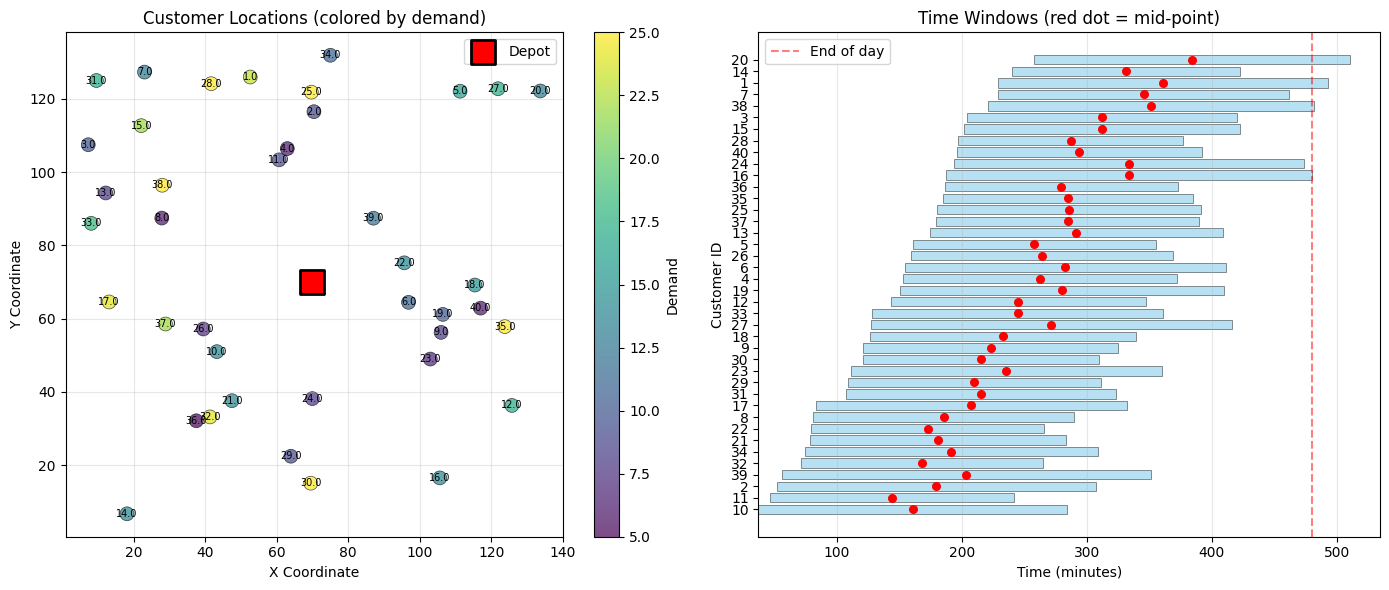

Intermediate dataset: 


⚙️ Adjusting vehicles from 10 → 17 to achieve ~65% utilization.

 Dataset Statistics:
  Customers: 100
  Vehicles: 17
  Vehicle capacity: 150
  Total demand: 1579.0
  Fleet capacity: 2550
  Utilization: 61.9% (target: 65%)
  Average demand per customer: 15.8
  Average time window width: 299.5 minutes
  Depot operating window: 0–720 min (12.0 hours)

  Time of day distribution:
    Morning (0–2h): 25
    Midday (2–4h): 64
    Afternoon (4h+): 11

  Window flexibility:
    Tight (<2h): 0
    Moderate (2–3h): 0
    Flexible (≥3h): 100

 Visualization saved to vrptw_medium_visualization.png


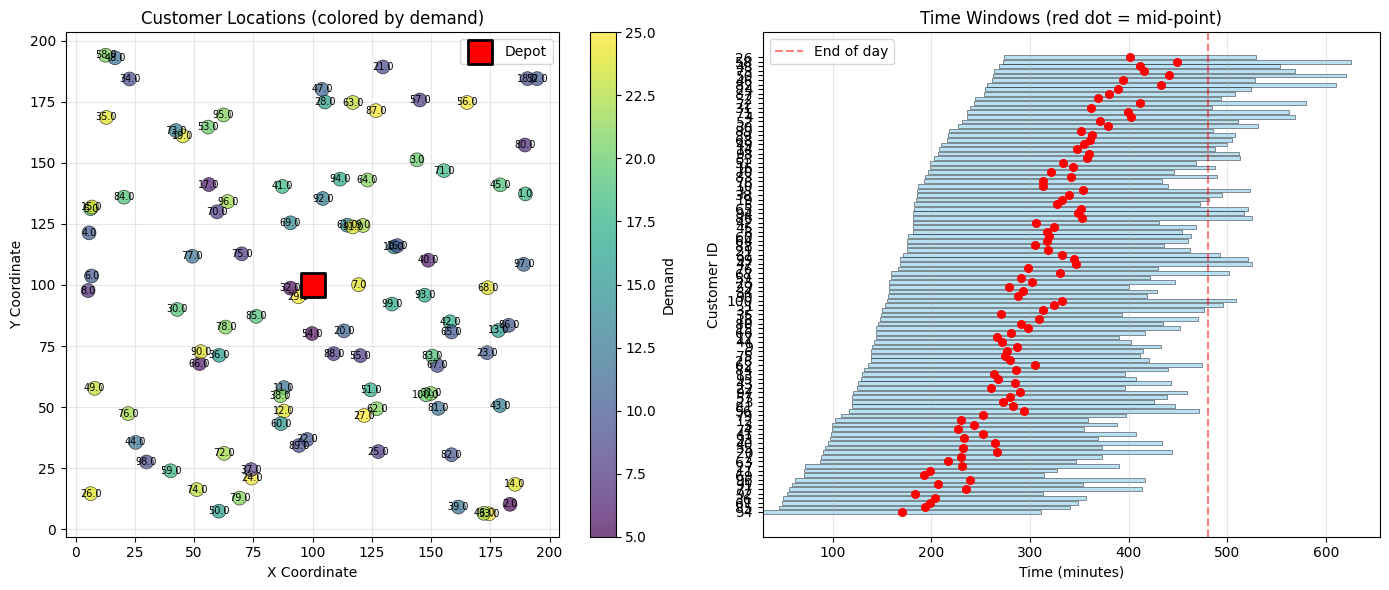

Advanced dataset: 


⚙️ Adjusting vehicles from 25 → 40 to achieve ~65% utilization.

 Dataset Statistics:
  Customers: 250
  Vehicles: 40
  Vehicle capacity: 150
  Total demand: 3830.0
  Fleet capacity: 6000
  Utilization: 63.8% (target: 65%)
  Average demand per customer: 15.3
  Average time window width: 395.1 minutes
  Depot operating window: 0–1080 min (18.0 hours)

  Time of day distribution:
    Morning (0–2h): 24
    Midday (2–4h): 127
    Afternoon (4h+): 99

  Window flexibility:
    Tight (<2h): 0
    Moderate (2–3h): 0
    Flexible (≥3h): 250

 Visualization saved to vrptw_hard_visualization.png


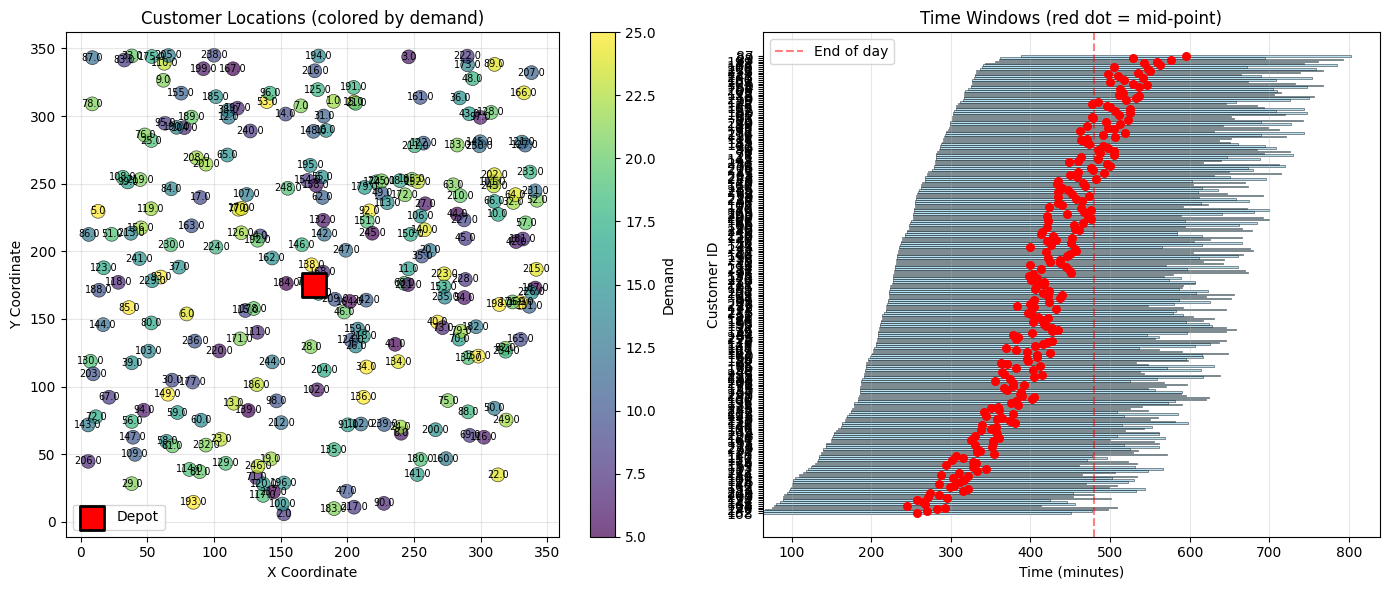


CLARKE-WRIGHT SAVINGS ALGORITHM
Route merging based on distance savings

  Computed 780 pairwise savings
  Top 5 savings:
    1. Merge C20-C27: saving = 144.50
    2. Merge C7-C31: saving = 142.14
    3. Merge C3-C31: saving = 137.10
    4. Merge C5-C27: saving = 129.83
    5. Merge C15-C31: saving = 128.28

  Starting with 40 individual routes
  Target: Merge down to ≤5 routes
  Attempting merges based on savings...
    ✓ Merged routes ending at C20 and starting at C27 (now 39 routes)
    ✓ Merged routes ending at C7 and starting at C31 (now 38 routes)
    ✓ Merged routes ending at C31 and starting at C3 (now 37 routes)
    ✓ Merged routes ending at C27 and starting at C5 (now 36 routes)
    ✓ Merged routes ending at C15 and starting at C7 (now 35 routes)
    ✓ Merged routes ending at C3 and starting at C13 (now 34 routes)
    ✓ Merged routes ending at C13 and starting at C33 (now 33 routes)
    ✓ Merged routes ending at C1 and starting at C28 (now 32 routes)
    ✓ Merged routes endi

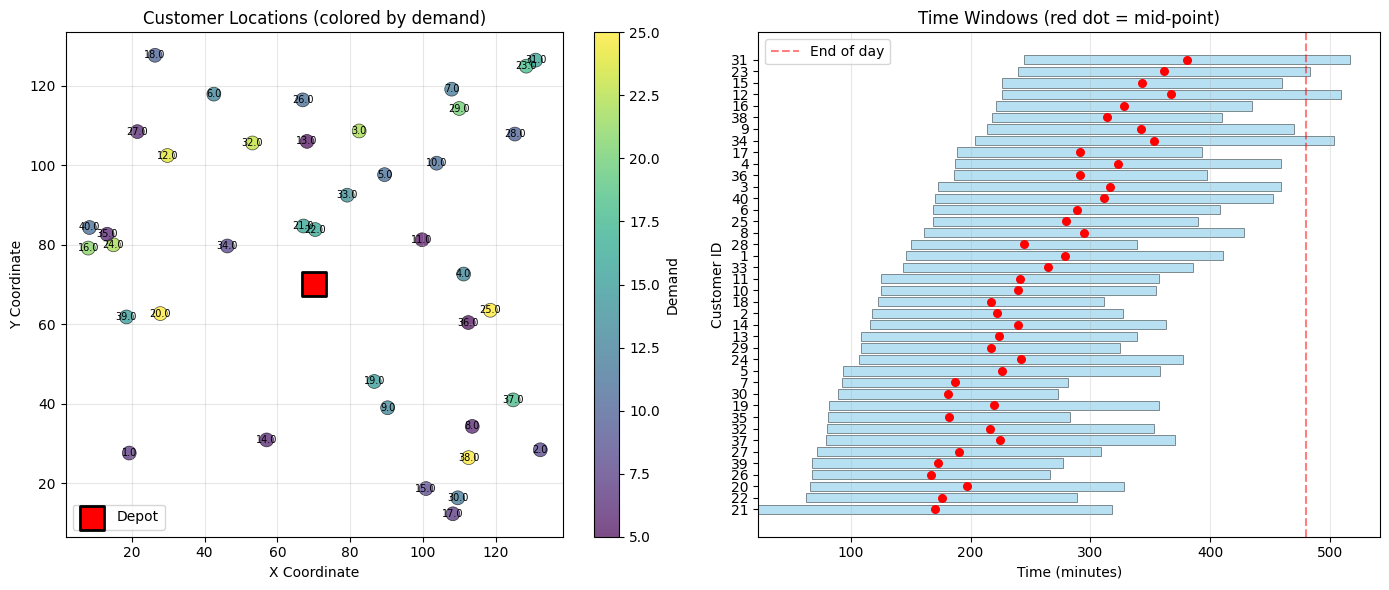

Intermediate dataset: 


⚙️ Adjusting vehicles from 10 → 16 to achieve ~65% utilization.

 Dataset Statistics:
  Customers: 100
  Vehicles: 16
  Vehicle capacity: 150
  Total demand: 1469.0
  Fleet capacity: 2400
  Utilization: 61.2% (target: 65%)
  Average demand per customer: 14.7
  Average time window width: 299.2 minutes
  Depot operating window: 0–720 min (12.0 hours)

  Time of day distribution:
    Morning (0–2h): 28
    Midday (2–4h): 67
    Afternoon (4h+): 5

  Window flexibility:
    Tight (<2h): 0
    Moderate (2–3h): 0
    Flexible (≥3h): 100

 Visualization saved to vrptw_medium_visualization.png


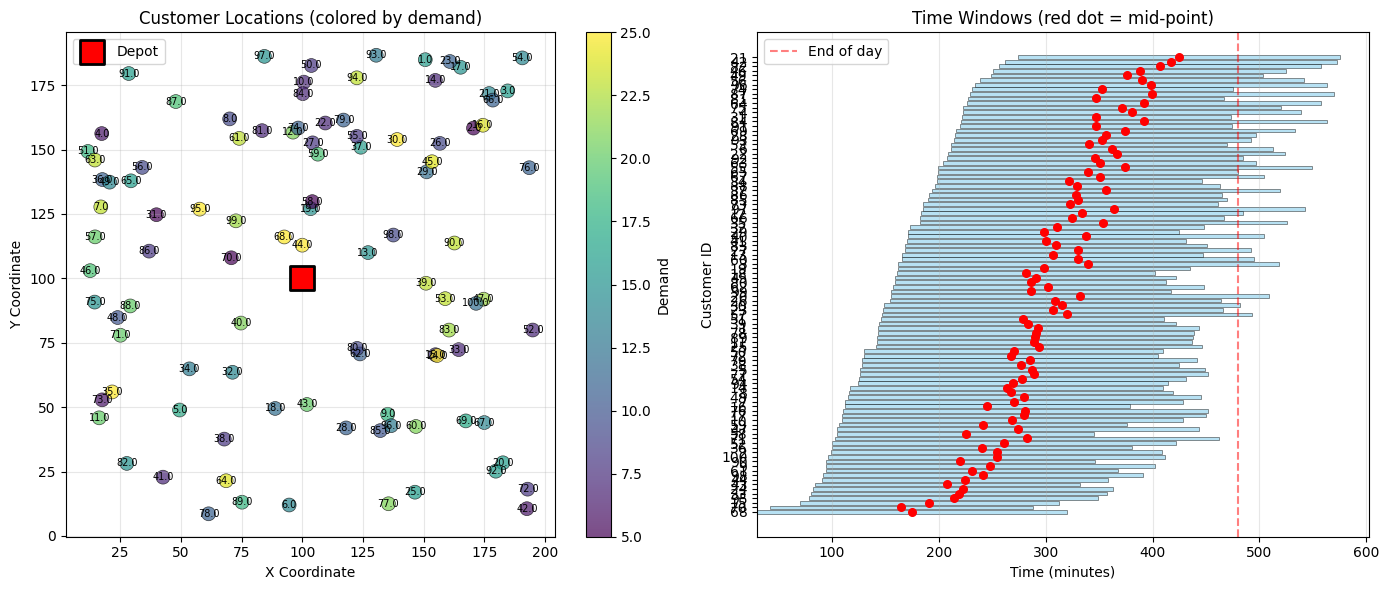

Advanced dataset: 


⚙️ Adjusting vehicles from 25 → 40 to achieve ~65% utilization.

 Dataset Statistics:
  Customers: 250
  Vehicles: 40
  Vehicle capacity: 150
  Total demand: 3899.0
  Fleet capacity: 6000
  Utilization: 65.0% (target: 65%)
  Average demand per customer: 15.6
  Average time window width: 392.6 minutes
  Depot operating window: 0–1080 min (18.0 hours)

  Time of day distribution:
    Morning (0–2h): 23
    Midday (2–4h): 132
    Afternoon (4h+): 95

  Window flexibility:
    Tight (<2h): 0
    Moderate (2–3h): 0
    Flexible (≥3h): 250

 Visualization saved to vrptw_hard_visualization.png


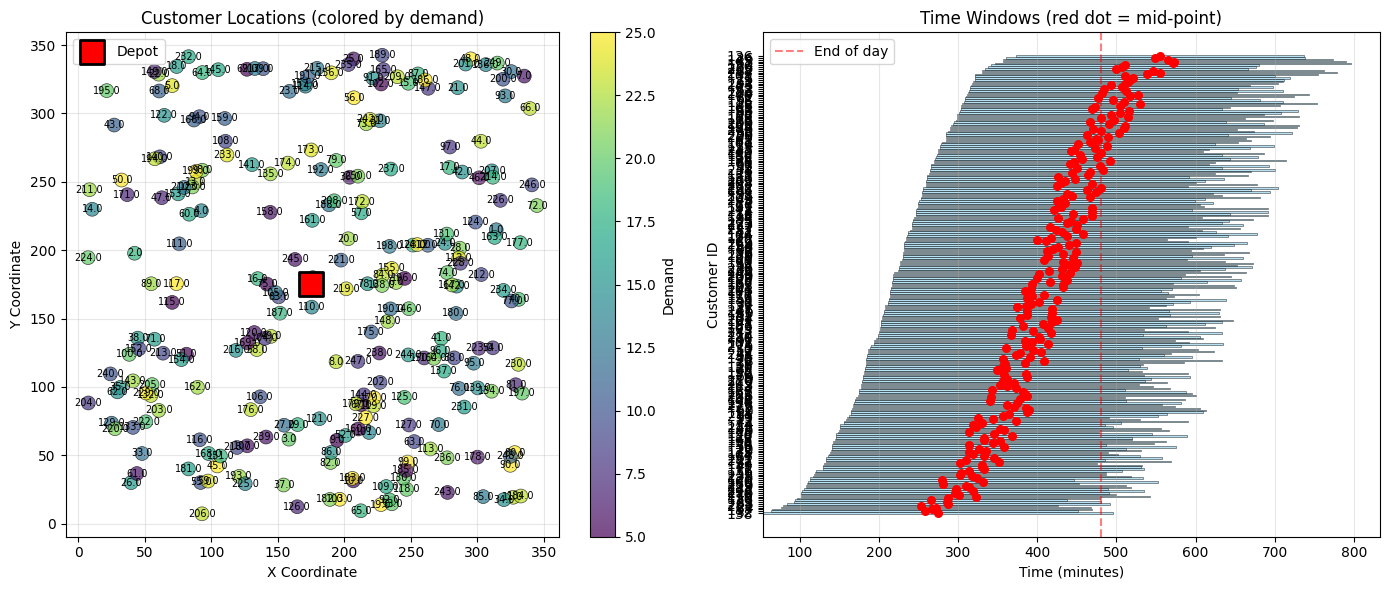


CLARKE-WRIGHT SAVINGS ALGORITHM
Route merging based on distance savings

  Computed 780 pairwise savings
  Top 5 savings:
    1. Merge C23-C31: saving = 160.11
    2. Merge C17-C30: saving = 131.59
    3. Merge C28-C31: saving = 130.46
    4. Merge C23-C28: saving = 129.64
    5. Merge C2-C37: saving = 122.19

  Starting with 40 individual routes
  Target: Merge down to ≤5 routes
  Attempting merges based on savings...
    ✓ Merged routes ending at C23 and starting at C31 (now 39 routes)
    ✓ Merged routes ending at C17 and starting at C30 (now 38 routes)
    ✓ Merged routes ending at C31 and starting at C28 (now 37 routes)
    ✓ Merged routes ending at C2 and starting at C37 (now 36 routes)
    ✓ Merged routes ending at C7 and starting at C23 (now 35 routes)
    ✓ Merged routes ending at C16 and starting at C40 (now 34 routes)
    ✓ Merged routes ending at C15 and starting at C17 (now 33 routes)
    ✓ Merged routes ending at C30 and starting at C38 (now 32 routes)
    ✓ Merged route

In [20]:
synthetic_results = []

for i in range(0,2):
    temp_results=[]
    
    generated_datasets = generate_multiple_datasets()
    easy_graph = generated_datasets['easy']
    intermediate_graph = generated_datasets['medium']
    advanced_graph = generated_datasets['hard']


    heuristics = ClassicalVRPTWHeuristics(easy_graph[0],easy_graph[1])
    solution1, solve_time1 = heuristics.nearest_neighbor()
    temp_results.append({
        'instance': f'easy_{i} NN',
        'solved': solution1 is not None,
        'time': solve_time1
    })
    solution2, solve_time2 = heuristics.savings_algorithm()
    temp_results.append({
        'instance': f'easy_{i} Savings',
        'solved': solution1 is not None,
        'time': solve_time1
    })
    solution3, solve_time3 = heuristics.sweep_algorithm()
    temp_results.append({
        'instance': f'easy_{i} Sweep',
        'solved': solution1 is not None,
        'time': solve_time1
    })
    heuristics = ClassicalVRPTWHeuristics(intermediate_graph[0],intermediate_graph[1])
    solution1, solve_time1 = heuristics.nearest_neighbor()
    temp_results.append({
        'instance': f'easy_{i} NN',
        'solved': solution1 is not None,
        'time': solve_time1
    })
    solution2, solve_time2 = heuristics.savings_algorithm()
    temp_results.append({
        'instance': f'easy_{i} Savings',
        'solved': solution1 is not None,
        'time': solve_time1
    })
    solution3, solve_time3 = heuristics.sweep_algorithm()
    temp_results.append({
        'instance': f'easy_{i} Sweep',
        'solved': solution1 is not None,
        'time': solve_time1
    })
    
    heuristics = ClassicalVRPTWHeuristics(advanced_graph[0],advanced_graph[1])
    solution1, solve_time1 = heuristics.nearest_neighbor()
    temp_results.append({
        'instance': f'easy_{i} NN',
        'solved': solution1 is not None,
        'time': solve_time1
    })
    solution2, solve_time2 = heuristics.savings_algorithm()
    temp_results.append({
        'instance': f'easy_{i} Savings',
        'solved': solution1 is not None,
        'time': solve_time1
    })
    solution3, solve_time3 = heuristics.sweep_algorithm()
    temp_results.append({
        'instance': f'easy_{i} Sweep',
        'solved': solution1 is not None,
        'time': solve_time1
    })
    synthetic_results.append(temp_results)
    






In [21]:
count_true = 0
count_false = 0
for sublist in synthetic_results:
    for entry in sublist:
        if entry['solved'] == True:
            count_true += 1
        if entry['solved'] == False:
            count_false += 1

print(f"Number of solved graphs is {count_true}")
print(f"Accuracy over 2 iterations of generated instances is {count_true/(count_true+count_false) *100} %")

Number of solved graphs is 18
Accuracy over 2 iterations of generated instances is 100.0 %


In [22]:
heuristics = ClassicalVRPTWHeuristics(df_test1, vehicle_info_test1)

solution_nn, time_nn = heuristics.nearest_neighbor()
print(f"Total distance: {solution_nn['total_distance']:.2f}")
print(f"Customers visited: {solution_nn['customers_visited']}/{solution_nn['customers_total']}")
print(f"Feasible: {solution_nn['feasible']}")
print(f"Solve time: {time_nn:.3f}s")

solution_savings, time_savings = heuristics.savings_algorithm()
print(f"Total distance: {solution_savings['total_distance']:.2f}")
print(f"Feasible: {solution_savings['feasible']}")
print(f"Solve time: {time_savings:.3f}s")

solution_sweep, time_sweep = heuristics.sweep_algorithm()
print(f"Total distance: {solution_sweep['total_distance']:.2f}")
print(f"Solve time: {time_sweep:.3f}s")


Total distance: 1870.69
Customers visited: 100/100
Feasible: True
Solve time: 0.531s

CLARKE-WRIGHT SAVINGS ALGORITHM
Route merging based on distance savings

  Computed 4950 pairwise savings
  Top 5 savings:
    1. Merge C70-C73: saving = 111.24
    2. Merge C70-C71: saving = 110.53
    3. Merge C71-C73: saving = 106.89
    4. Merge C71-C76: saving = 104.21
    5. Merge C73-C77: saving = 103.71

  Starting with 100 individual routes
  Target: Merge down to ≤25 routes
  Attempting merges based on savings...
    ✓ Merged routes ending at C70 and starting at C73 (now 99 routes)
    ✓ Merged routes ending at C71 and starting at C70 (now 98 routes)
    ✓ Merged routes ending at C76 and starting at C71 (now 97 routes)
    ✓ Merged routes ending at C73 and starting at C77 (now 96 routes)
    ✓ Merged routes ending at C77 and starting at C79 (now 95 routes)
    ✓ Merged routes ending at C78 and starting at C76 (now 94 routes)
    ✓ Merged routes ending at C79 and starting at C80 (now 93 route

## Benchmarking